# Animal Crossing New Horizons Character Popularity Analysis

In [1]:
import pandas as pd
import numpy as np 
import wrangle
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# import and prepare the data
- data acquired from local csv file, which was downloaded from kaggle
- added rank, tier, and is_successful columns to the csv file
- dropped the wallpaper, birthday, catchphrase, flooring, furniture, filename, and unique entry id
- got rid of spaces  in the column names
- manually filled in the null data from the animal crossing webpage
- included 22 characters that were missing from the original csv file, but were on the tier list

In [2]:
df = wrangle.get_acnh_data()

In [3]:
df = wrangle.prep_acnh_data(df)

In [4]:
df.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Marshal,1,1,Squirrel,Male,Smug,Music,K.K. Bossa,Elegant,Cool,Light blue,Blue,1
Raymond,2,1,Cat,Male,Smug,Nature,K.K. Cruisin',Elegant,Cool,Black,Gray,1
Shino,3,1,Deer,Female,Peppy,Education,K.K. Folk,Elegant,Gorgeous,Red,Black,1
Sasha,4,1,Rabbit,Male,Lazy,Fashion,K.K Robot Synth,Simple,Cute,Blue,White,1
Zucker,5,1,Octopus,Male,Lazy,Nature,Spring Blossoms,Simple,Cute,Blue,Yellow,1


In [5]:
df.shape

(413, 12)

### Before we split the dataframe into train, validate, and test I want to give a look at the count of the characters to show how the tier list is distributed

In [6]:
df.tier.value_counts()

6    163
5    120
4     60
3     30
2     25
1     15
Name: tier, dtype: int64

In [7]:
# if a character falls within the top 3 tiers, they are marked as being successful in the is successful column
# this accounts for about 17% of the total characters
round(70/413,2)*100

17.0

In [8]:
# now, time to split the data into train, validate, and test for the exploration phase
train, validate, test = wrangle.split_acnh_data(df)

In [9]:
train.shape, validate.shape, test.shape

((280, 12), (71, 12), (62, 12))

### Some points to make before starting exploration

- I'm not seeing these as characters in a game, but rather products that can be marketed in to consumers and the traits of the characters are attributes that the product would have

- Being in tier 1, 2, or 3 determines whether or not a character is successful
    - This corresponds with a rank between 1-70. A rank of 70+ puts the character in tier 4-6 and thus makes it unsuccessful

- I want to see what possible attributes could be influencing the popularity of these products and, hopefully, make recommendations on what attributes we can combine in the future to make products that are more likely to be popular. 

- I also want to test whether a new, unseen, character would be successful based on the combination of attributes that it is given

- Key point in this project is that I will not be using "cuteness" of a character as a factor, since cuteness is a matter of personal opinion so there is no real way to measure it. Plus some things are so ugly they can be cute. Additionally, there are some characters that can be considered cute that aren't successful and there are some characters that are not considered cute that do well. 

- Another side factor to consider is that color_1 is typically the color of the characters clothes. 

- I am leaving in favorite song, since it will be playing in the character's house. If a song really annoys a person, they could be less apt to keep that character. 

# Exploration

### Initial Hypotheses: 
- the species, hobby, and color_1 play a large part on whether or not a character will be successful
- while favorite_song might play a roll, i don't know that it will be significant enough to determine whether a character will be successful
- the style of the character will also play a role, since this will be tied in with how they look


In [21]:
# creating histplots for each column to get an idea of how each group within a column does
def column_hist_plots(train):
    for col in train.drop(columns = 'position').columns:
        plt.figure(figsize=(30,15))
        sns.set(font_scale=2.5)
        plt.xticks(rotation=45)
        sns.histplot(data = train, x = col, hue = 'is_successful')

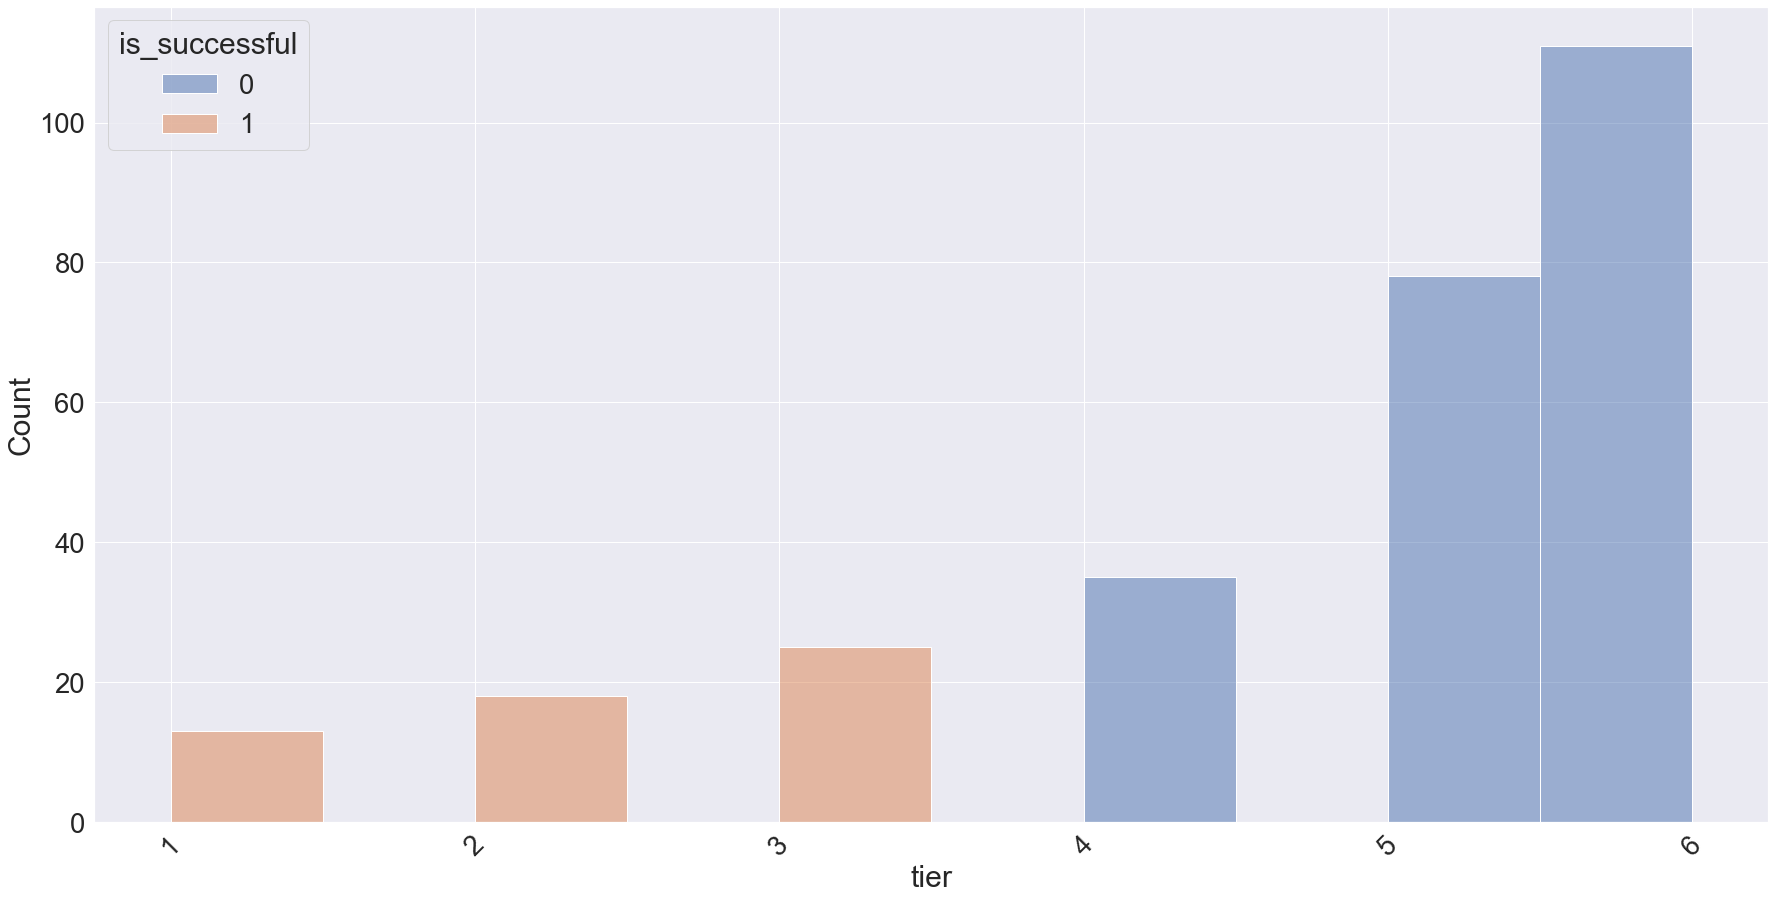

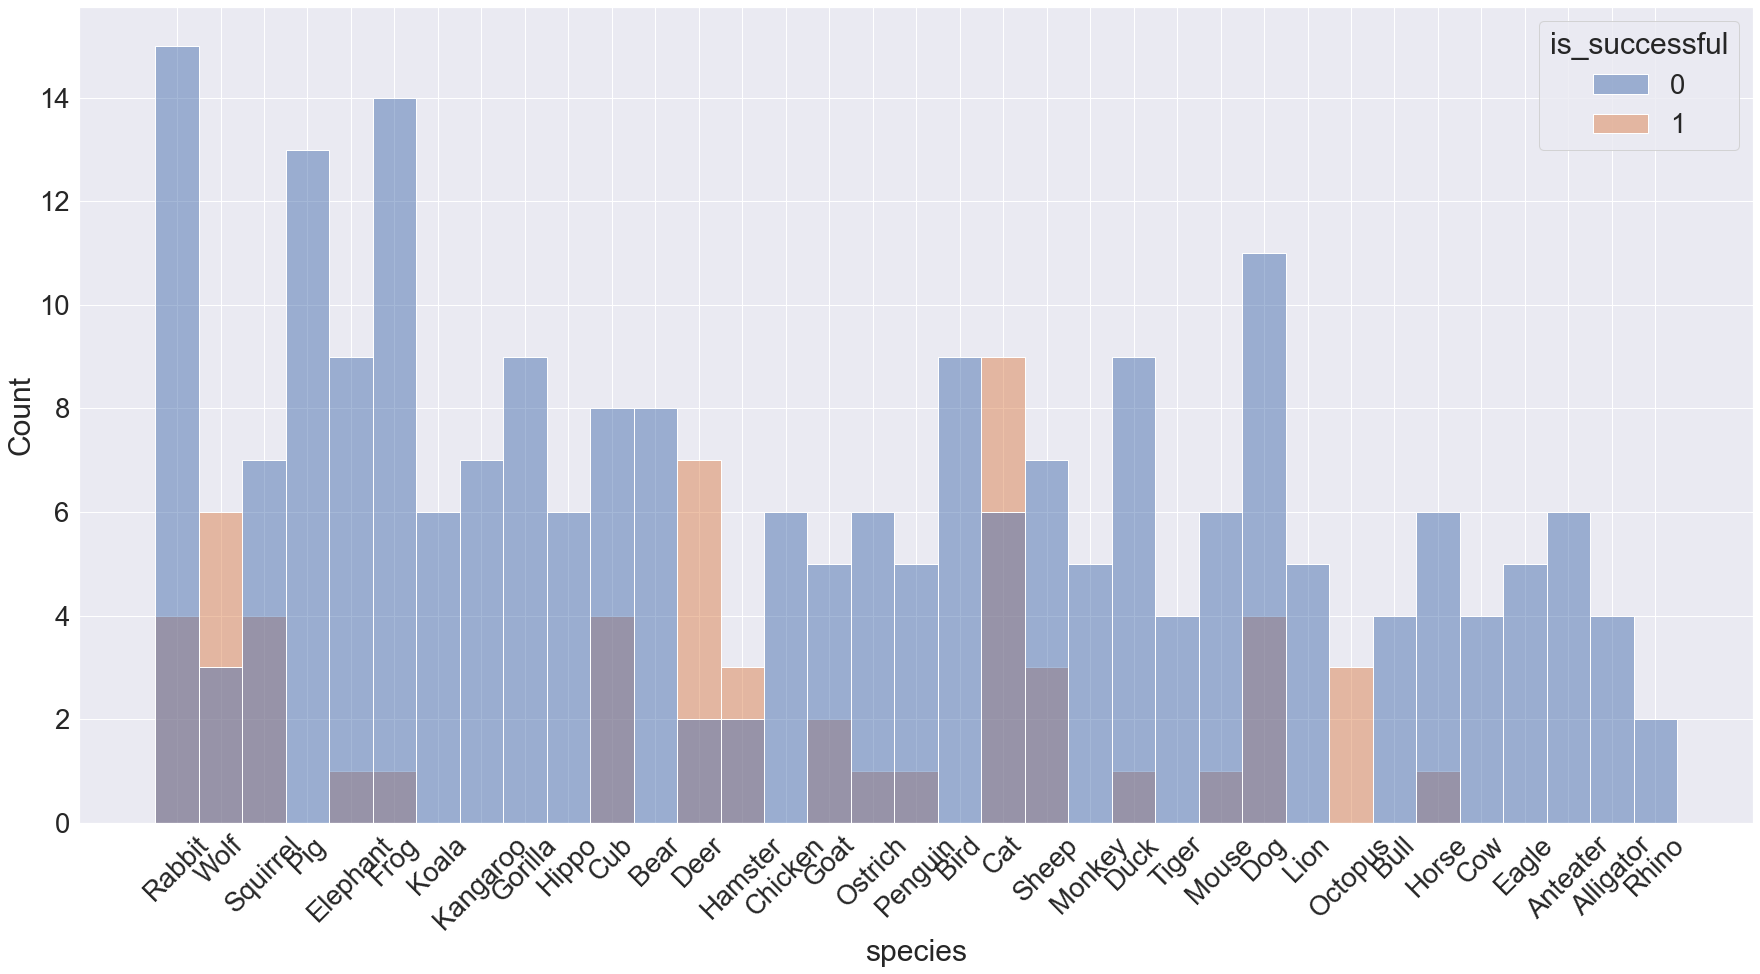

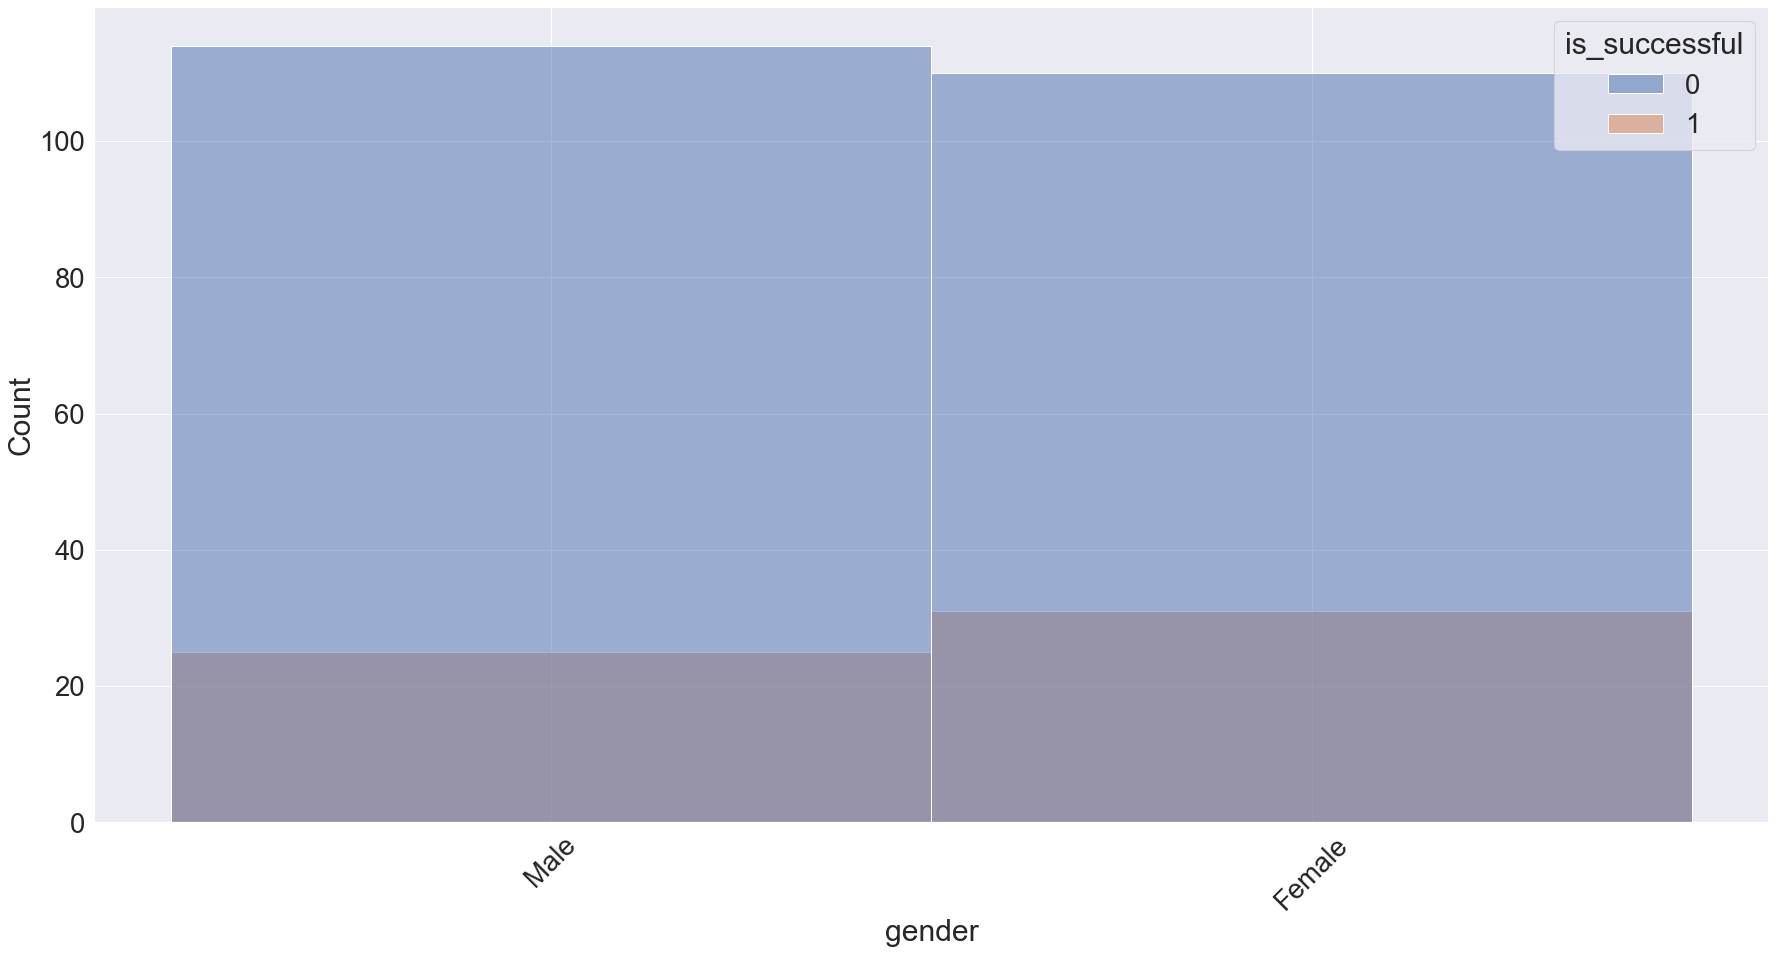

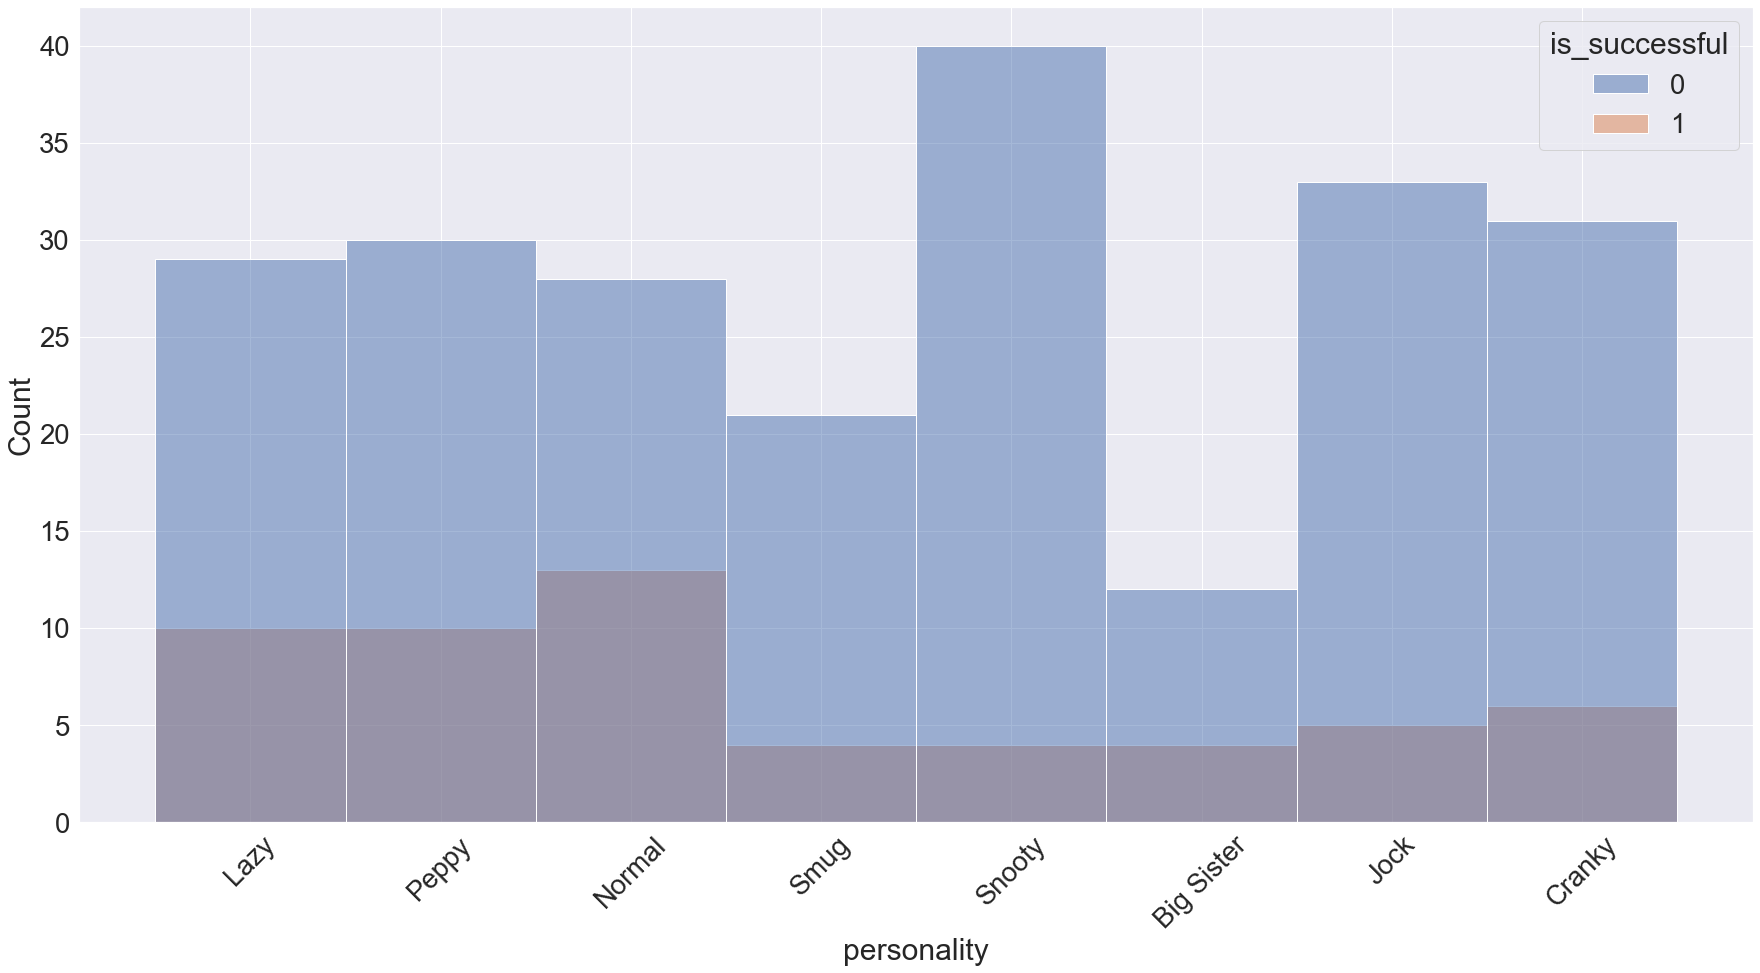

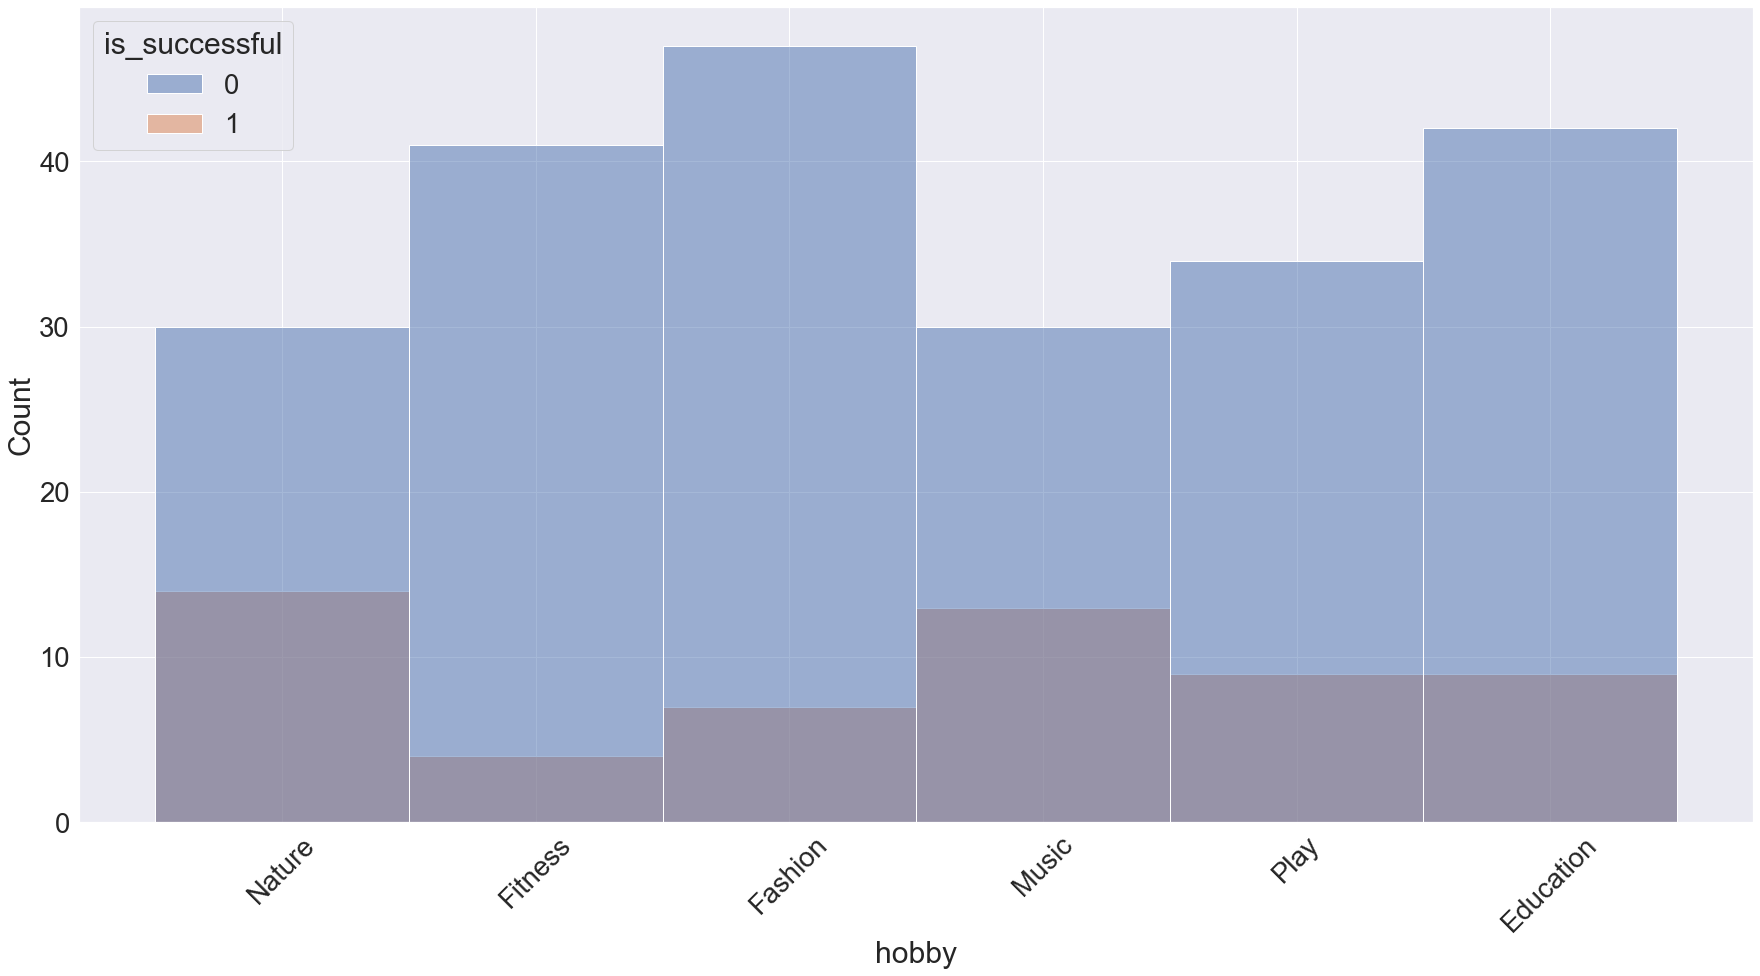

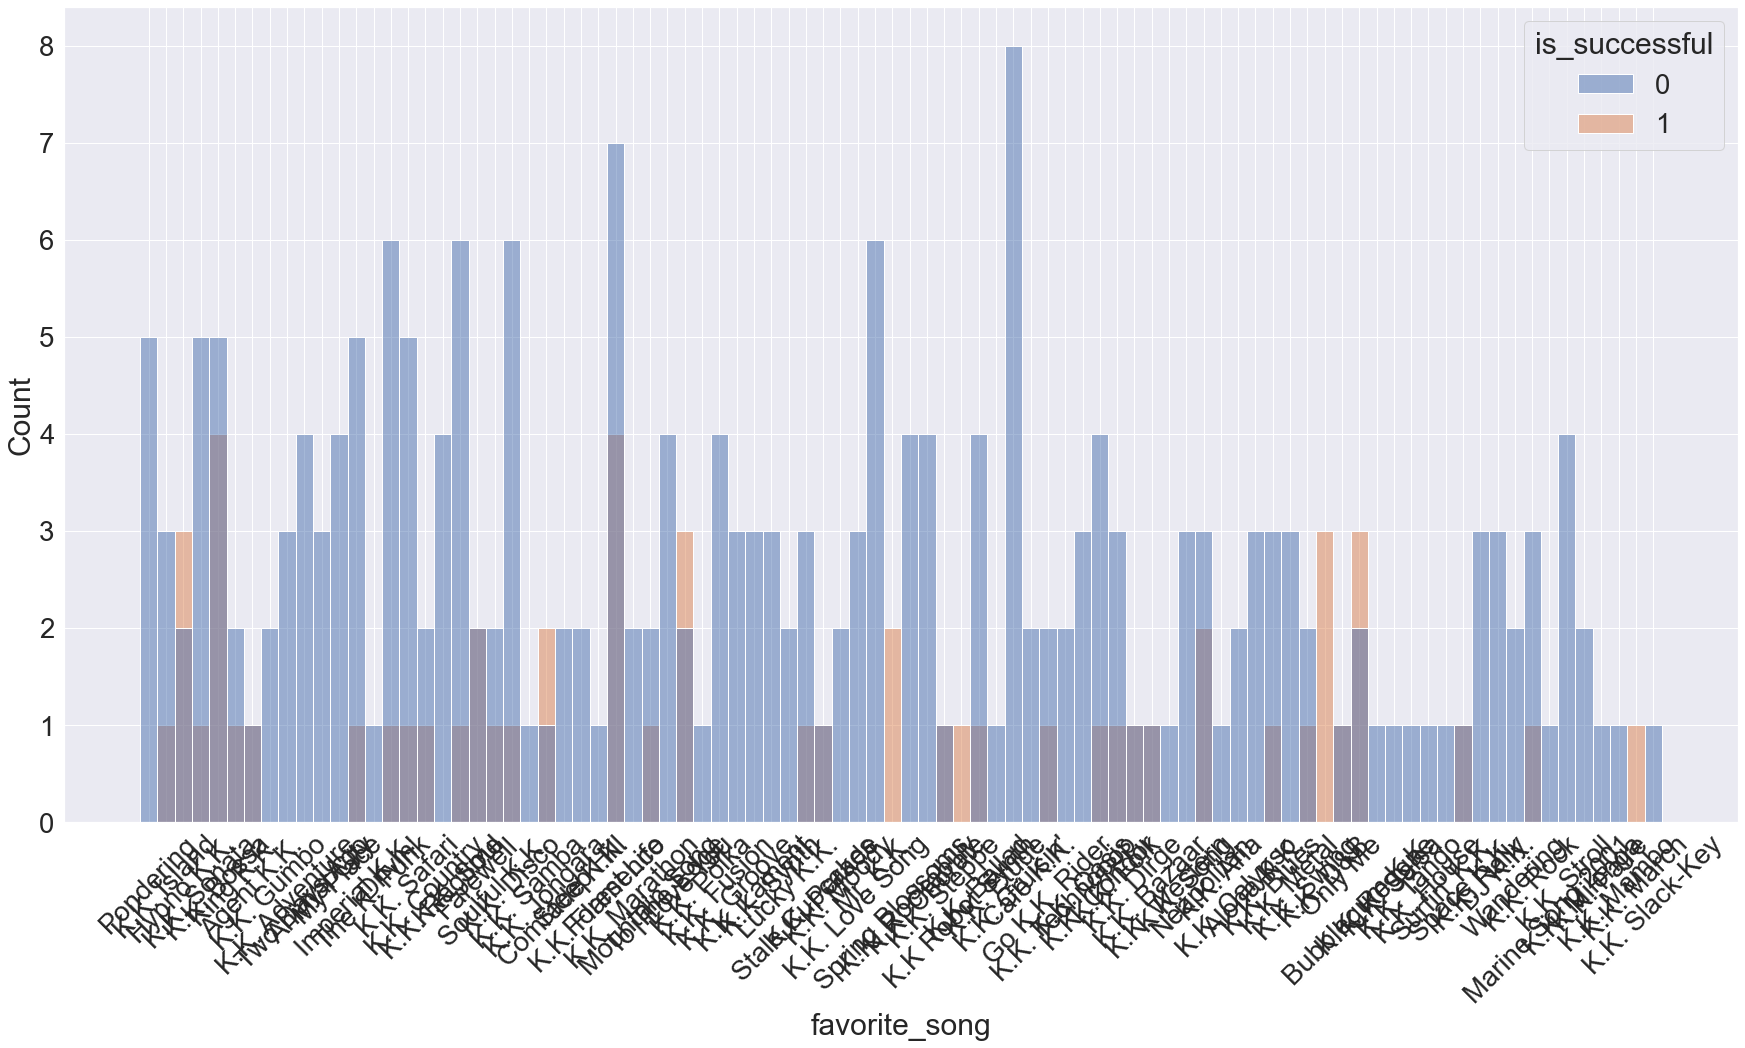

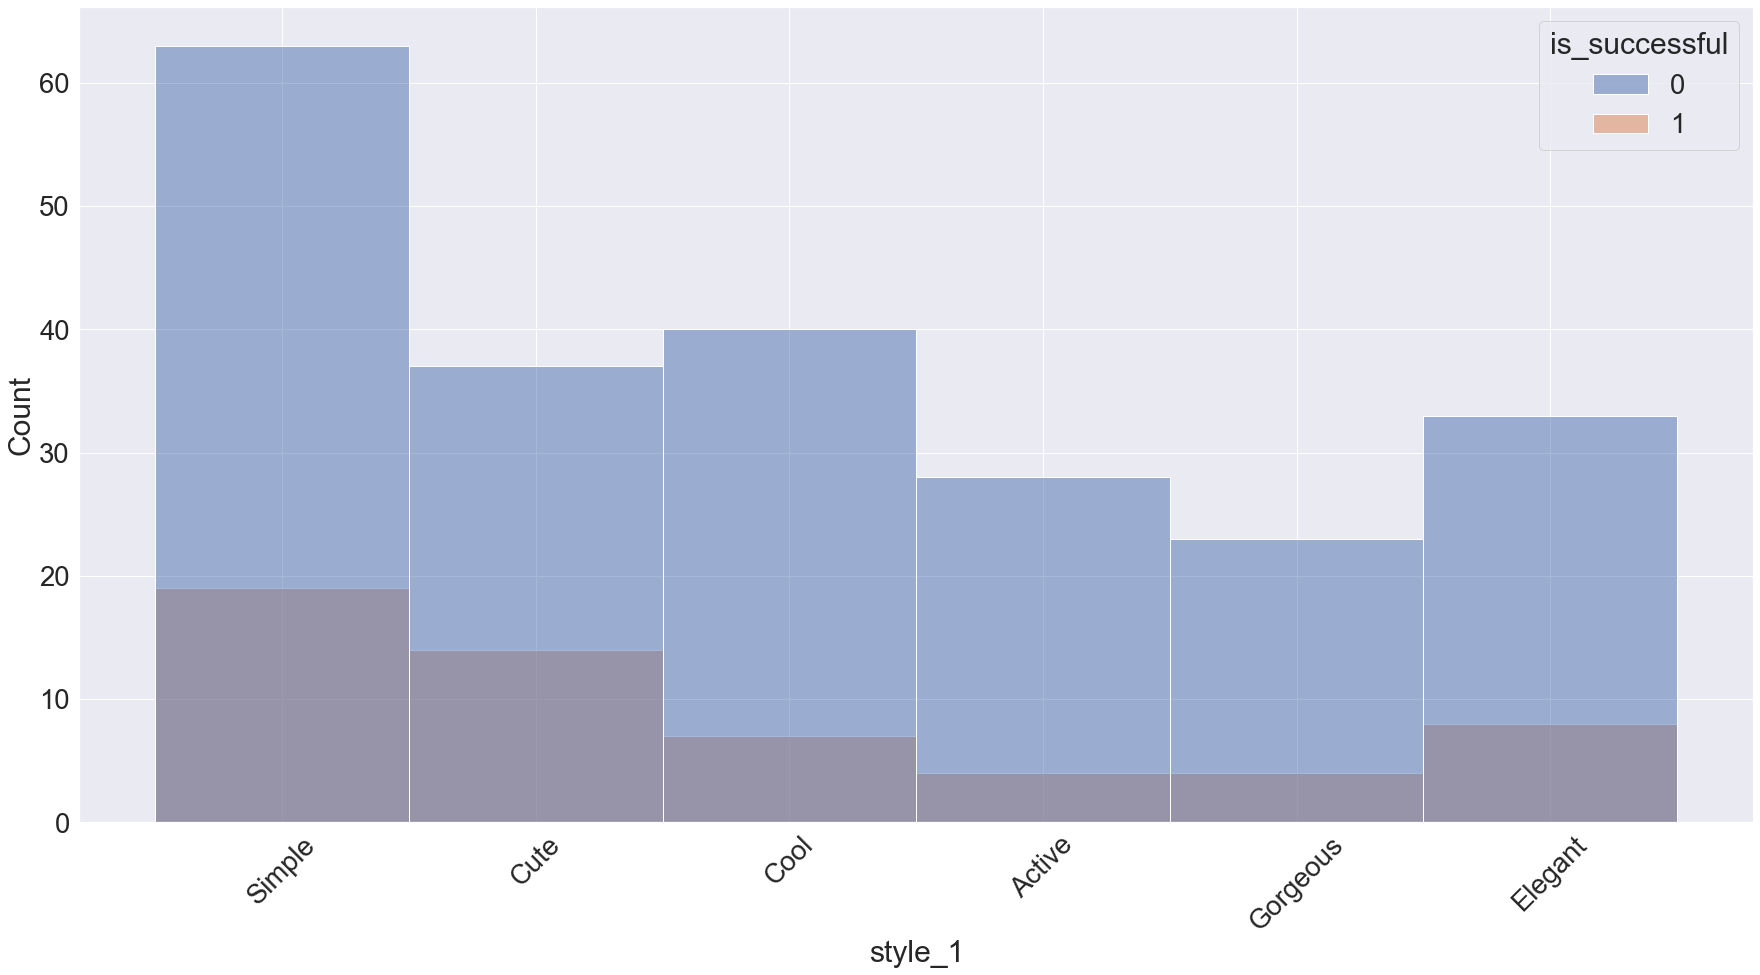

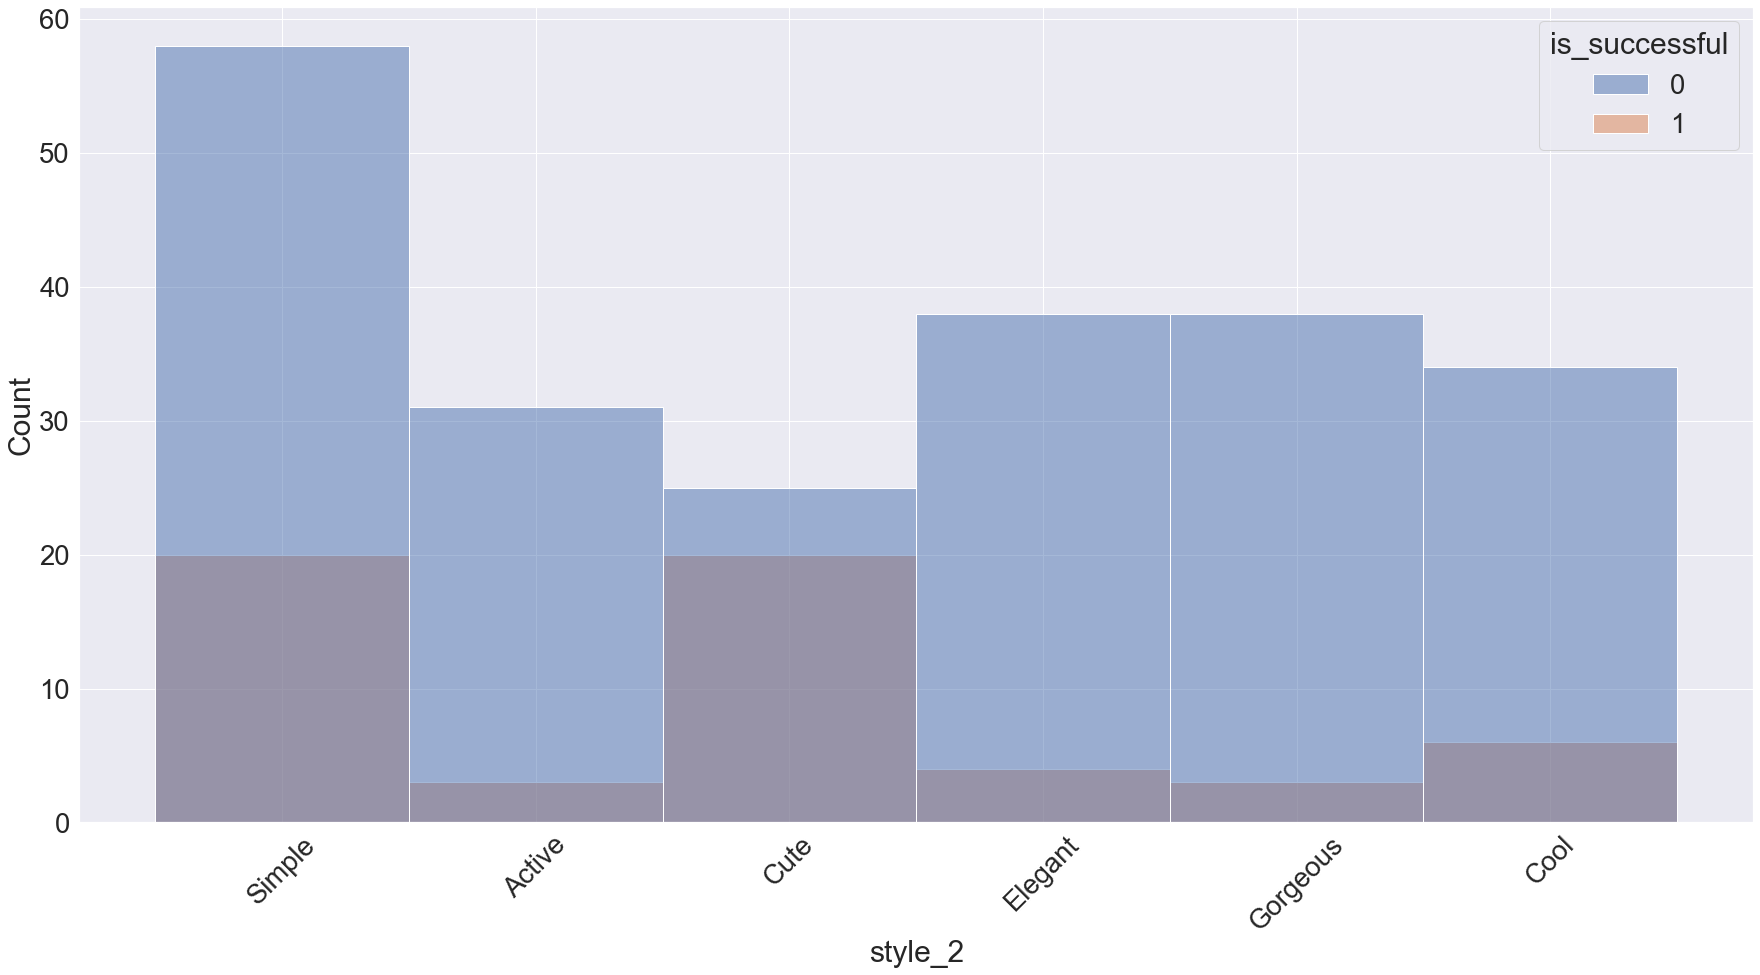

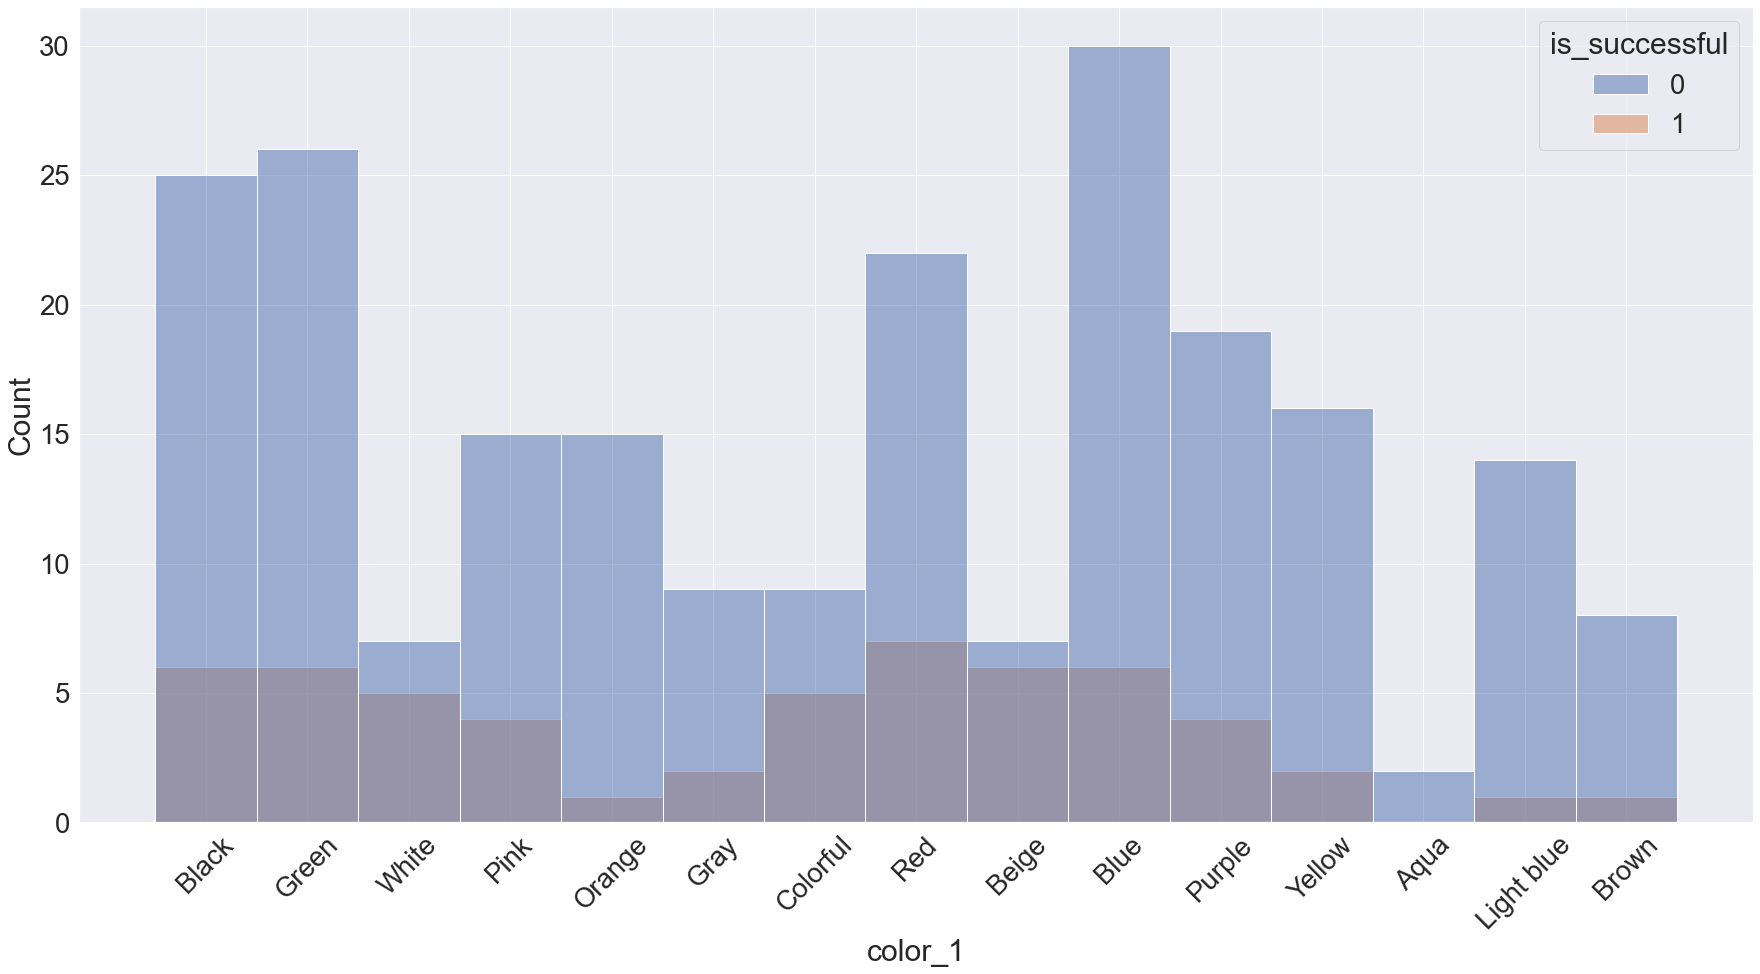

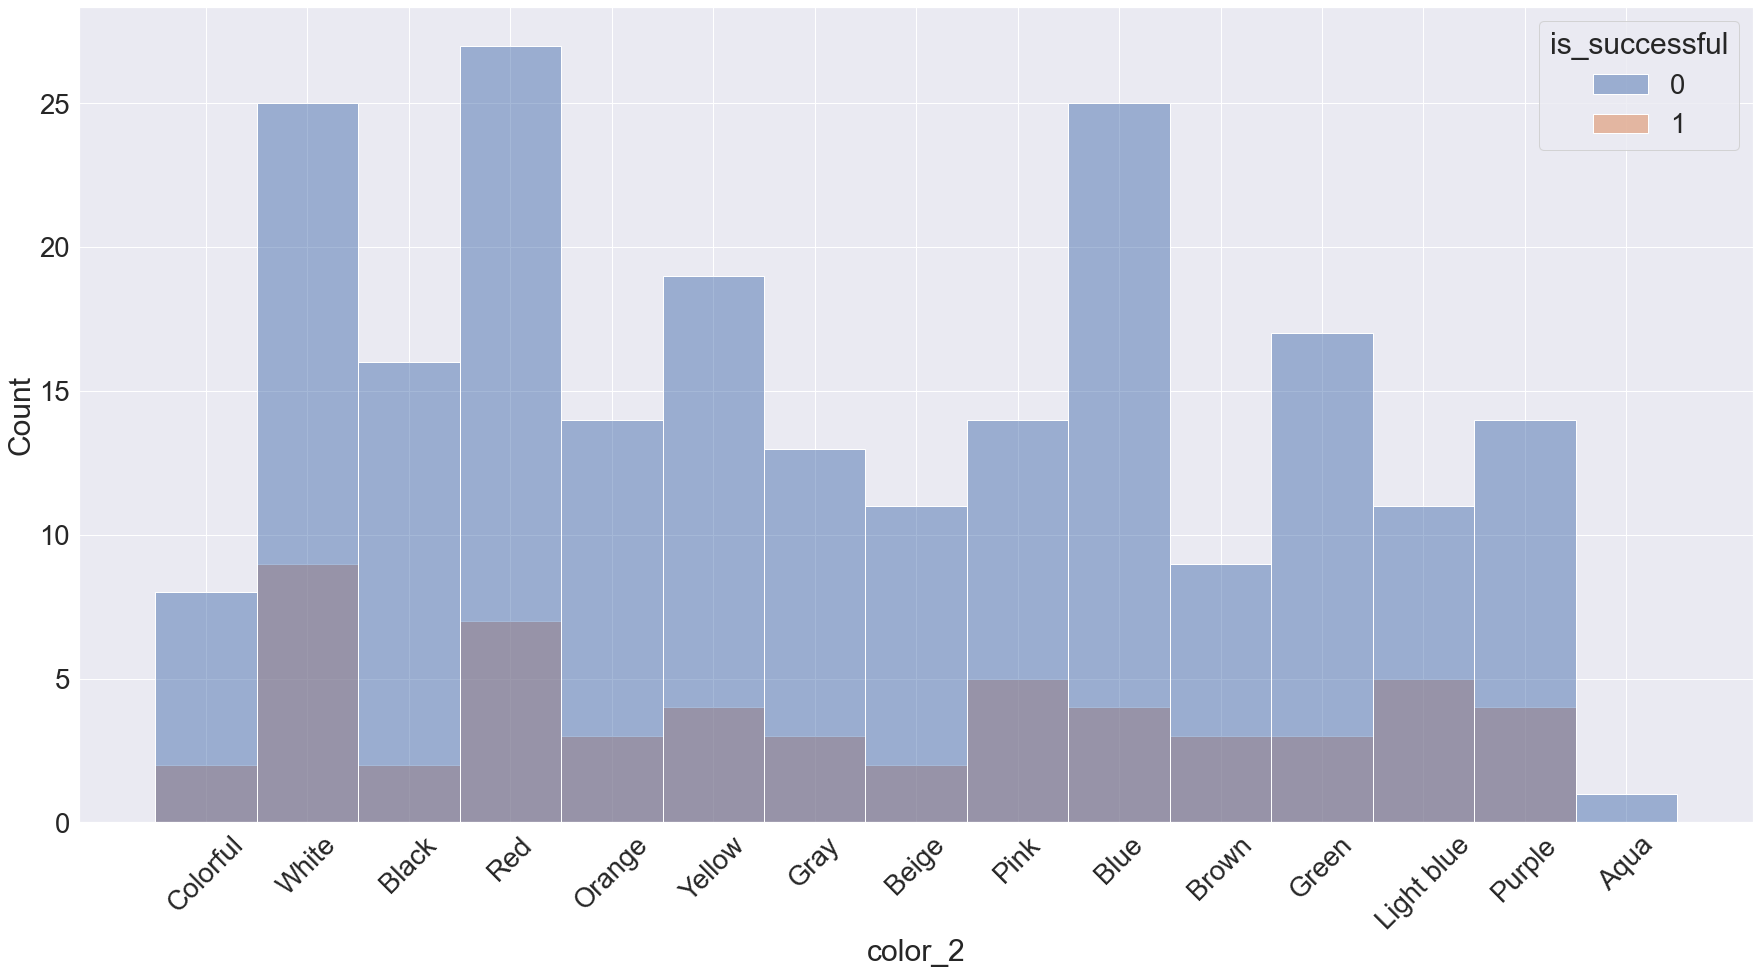

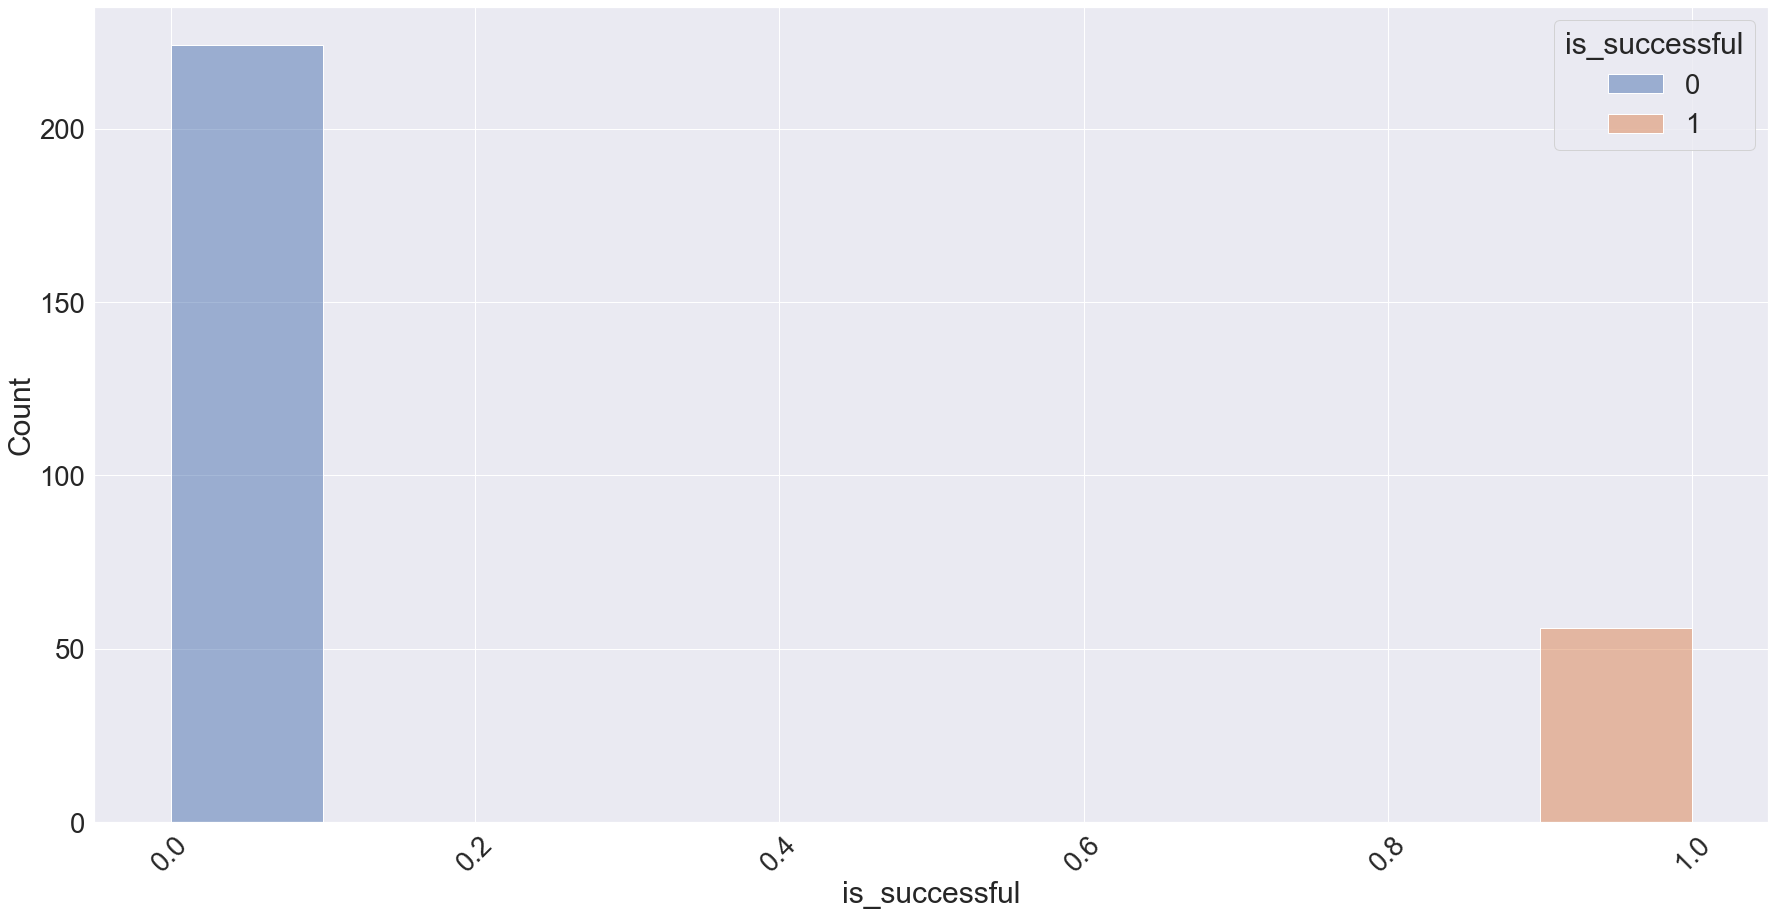

In [22]:
column_hist_plots(train)

### Takeaways: 
- The wolf, deer, hamster, cat, and octopus species have more successful characters than they have unsuccessful characters
    - There are multiple species with no successful characters
- Female characters seem to have a higher percentage of success than male characters
- The normal, lazy, peppy, and big sister columns seem to have the highest percents of success and the snooty seems to perform the worst. 
- The nature and music hobbies seem to do the best, and the fitness seems to do the worst. 
- The cute and simple style seem to perform the best for style_1
- The cute style does very well in style_2. The simple style still does well, the gorgeous style seems to do the worst
- Beige, white, and colorful are very successful colors for color 1. Orange is not very successful
- Brown, light blue, and white seem to do well while beige and black don't seem to do as well for color_2.

In [10]:
# establish an overall mean of the position column 
overall_mean = train.position.mean()

In [15]:
# create a dictionary that has the average position for the groups of each column

def trait_means_dicts(train):
    df_dict = {}

    for col in train.drop(columns = 'position').columns:
        df= train.groupby(col).mean()['position'].to_frame().reset_index().sort_values('position')
        df_dict[col] = df
    return df_dict

In [16]:
# display the entire dictionary

trait_means_dicts(train)

{'tier':    tier             position
 0     1                 8.46
 1     2                29.78
 2     3                55.72
 3     4               103.94
 4     5               190.72
 5     6               332.53,
 'species':       species             position
 25    Octopus                21.67
 34       Wolf                63.22
 9        Deer                71.22
 17    Hamster                89.20
 5         Cat                96.07
 32   Squirrel               118.55
 10        Dog               142.13
 31      Sheep               155.70
 8         Cub               155.92
 29     Rabbit               169.53
 27    Penguin               180.00
 15       Goat               182.86
 13   Elephant               184.10
 14       Frog               199.40
 26    Ostrich               204.14
 21      Koala               213.67
 12      Eagle               234.80
 7         Cow               244.25
 11       Duck               245.10
 19      Horse               249.14
 24      Mouse

In [17]:
# a list of the different dictionaries that cna be accessed with this function
list(trait_means_dicts(train))

['tier',
 'species',
 'gender',
 'personality',
 'hobby',
 'favorite_song',
 'style_1',
 'style_2',
 'color_1',
 'color_2',
 'is_successful']

In [18]:
# this dictionary allows me to access the mean position for each group of a category by knowing just the name of the column
# This can be used later for graphing the means of the group instead of each point
trait_means_dicts(train)['hobby']

,hobby,position
5,Play,170.42
4,Nature,171.05
3,Music,205.47
0,Education,214.24
1,Fashion,216.44
2,Fitness,248.02


In [19]:
# function takes the mean of the groups of each column and plots them against the average position
def column_scatter_plots(train):
    for col in train.drop(columns = 'position').columns:
        plt.figure(figsize=(30,15))
        sns.set(font_scale=2.5)
        plt.xticks(rotation=45)
        plt.axhline(overall_mean, color='r')
        sns.scatterplot(x=col, y='position', data=trait_means_dicts(train)[col],label='mean_overall', s=300)

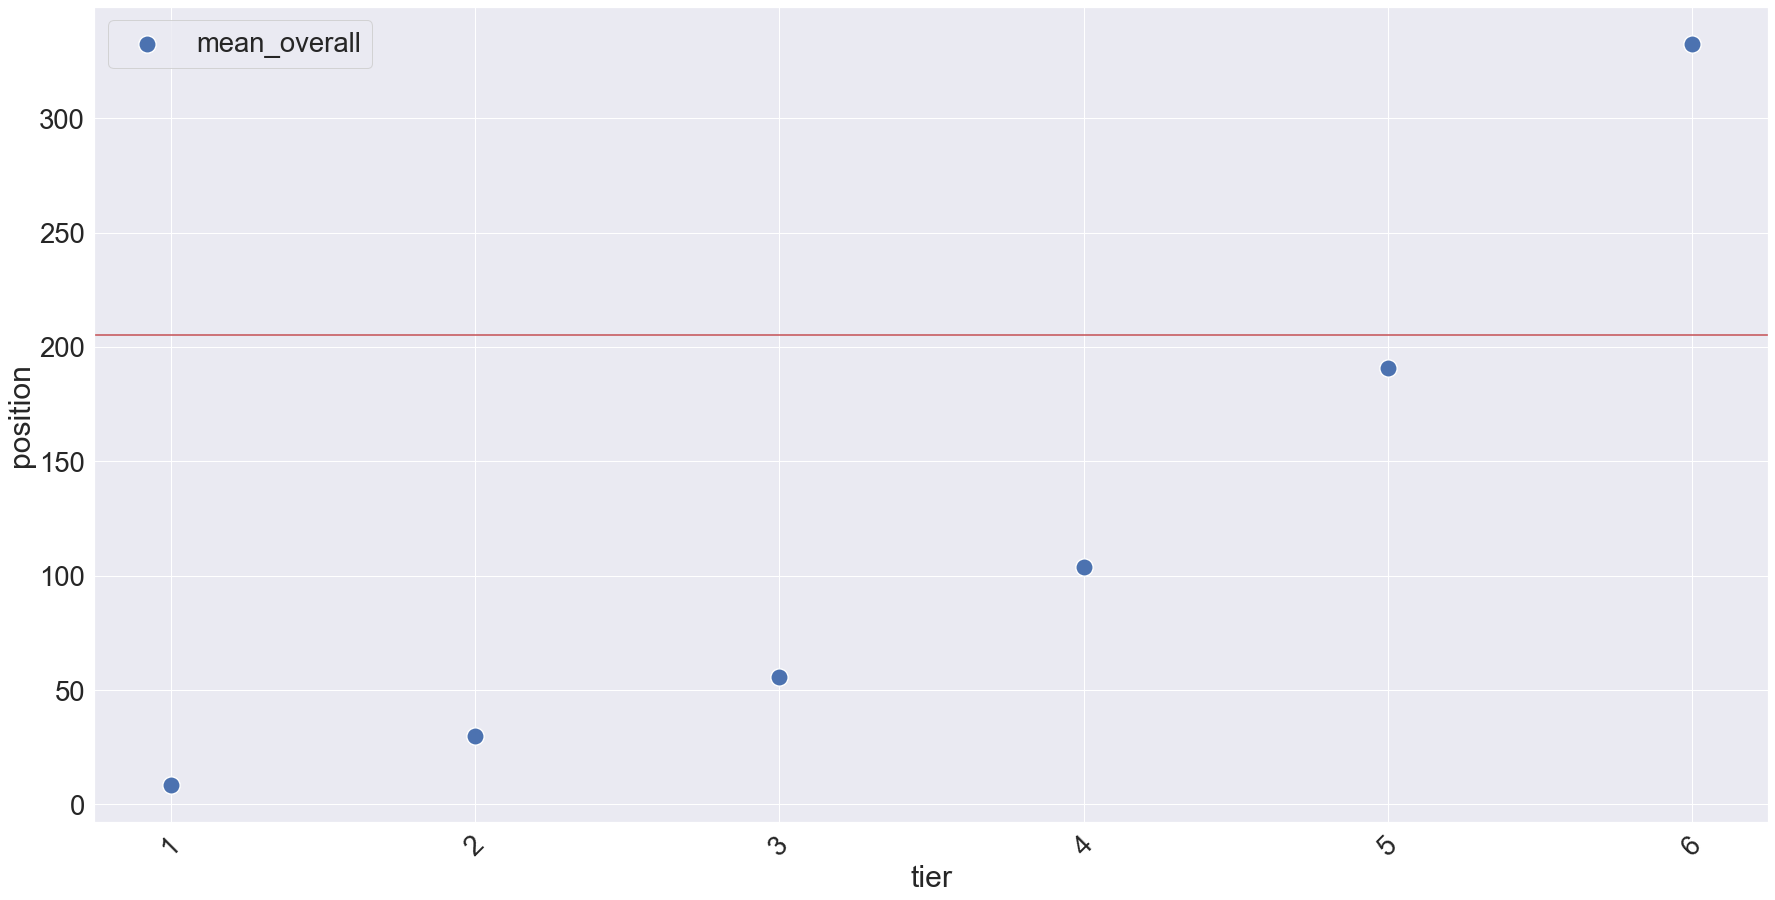

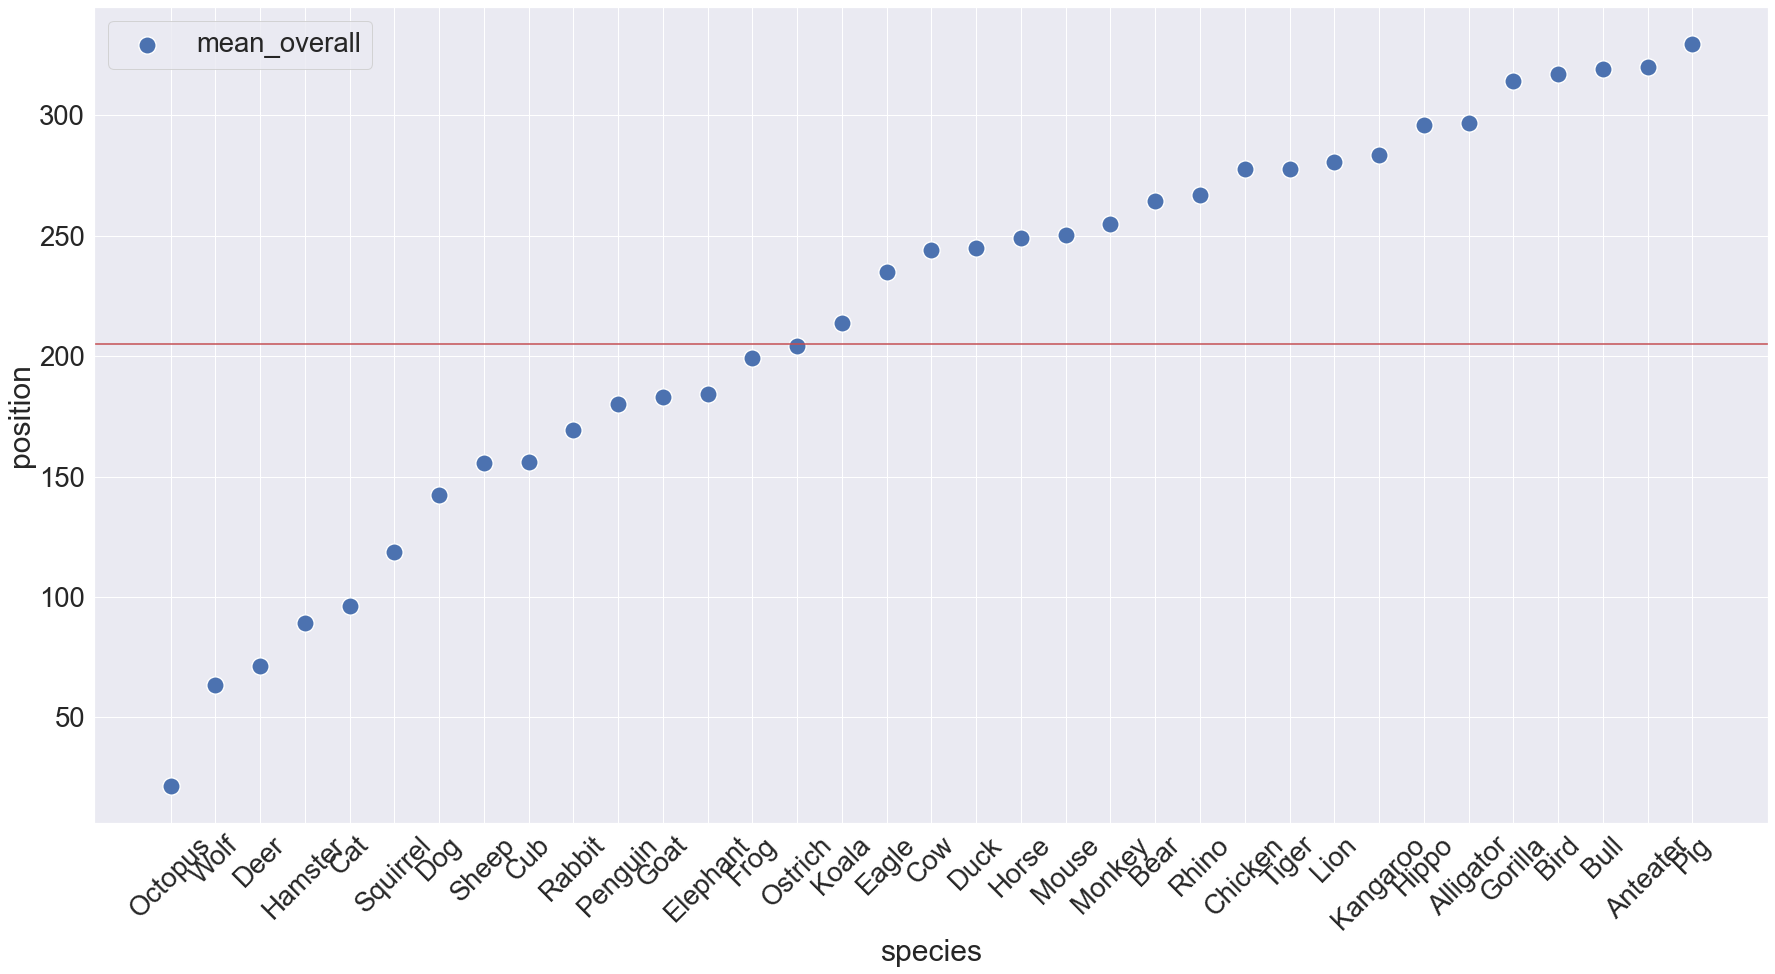

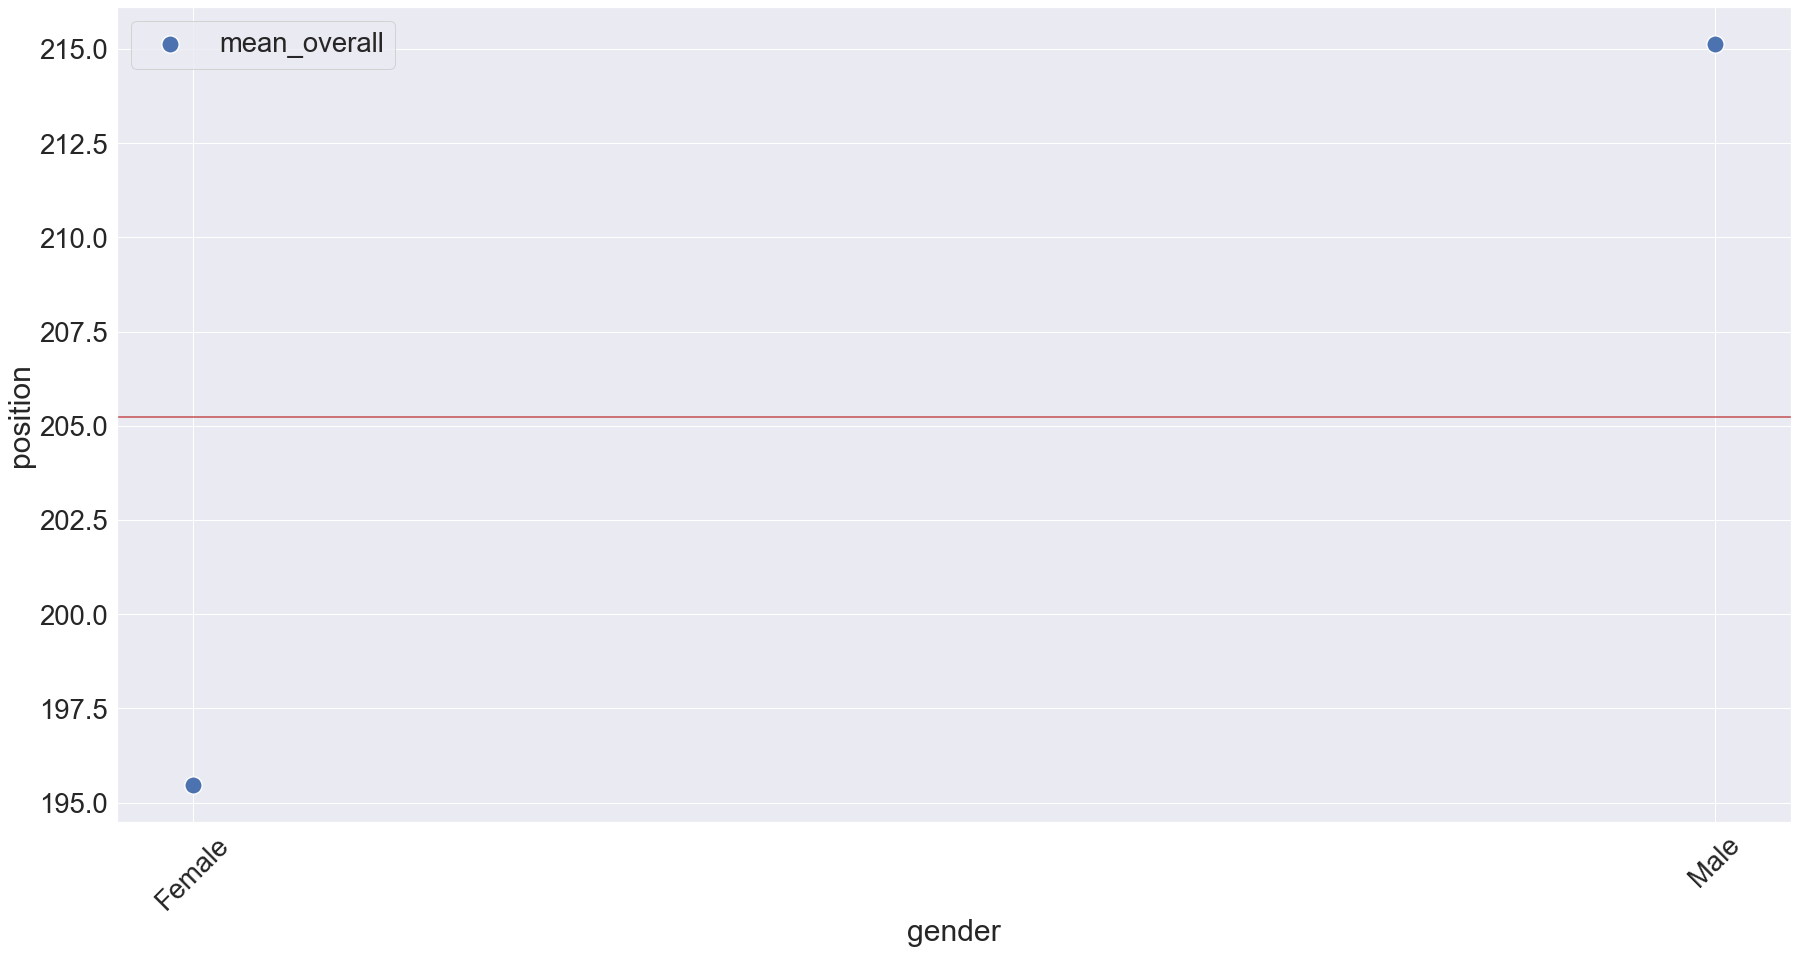

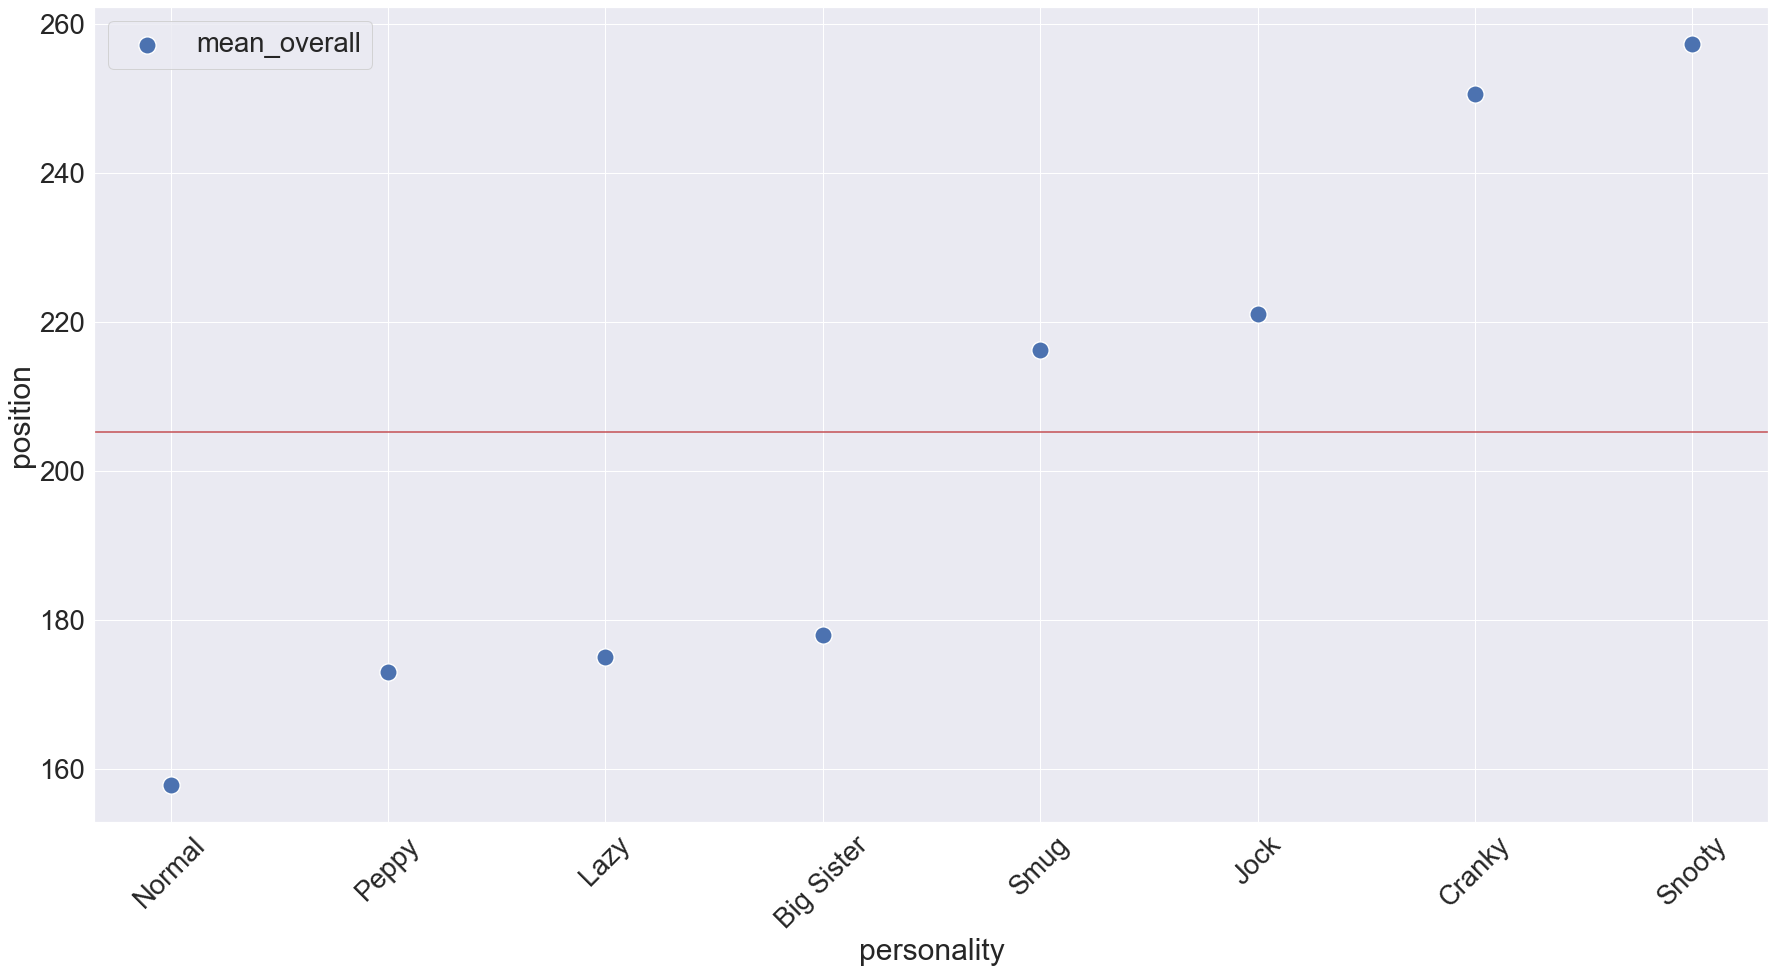

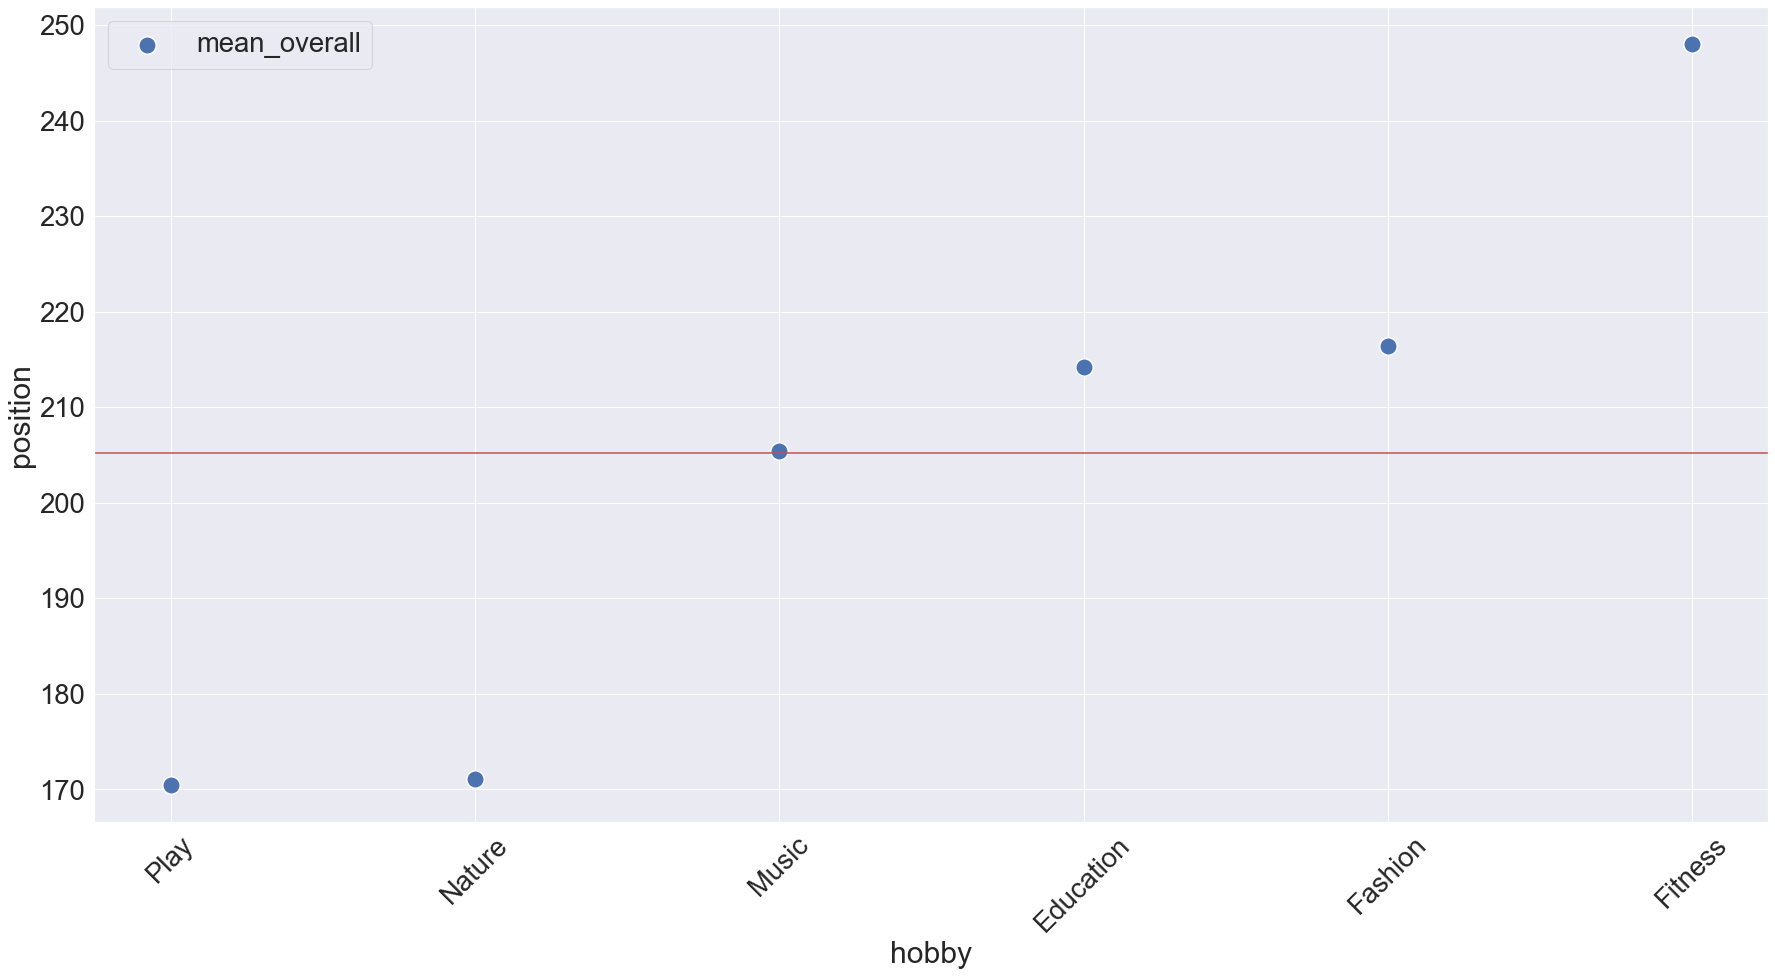

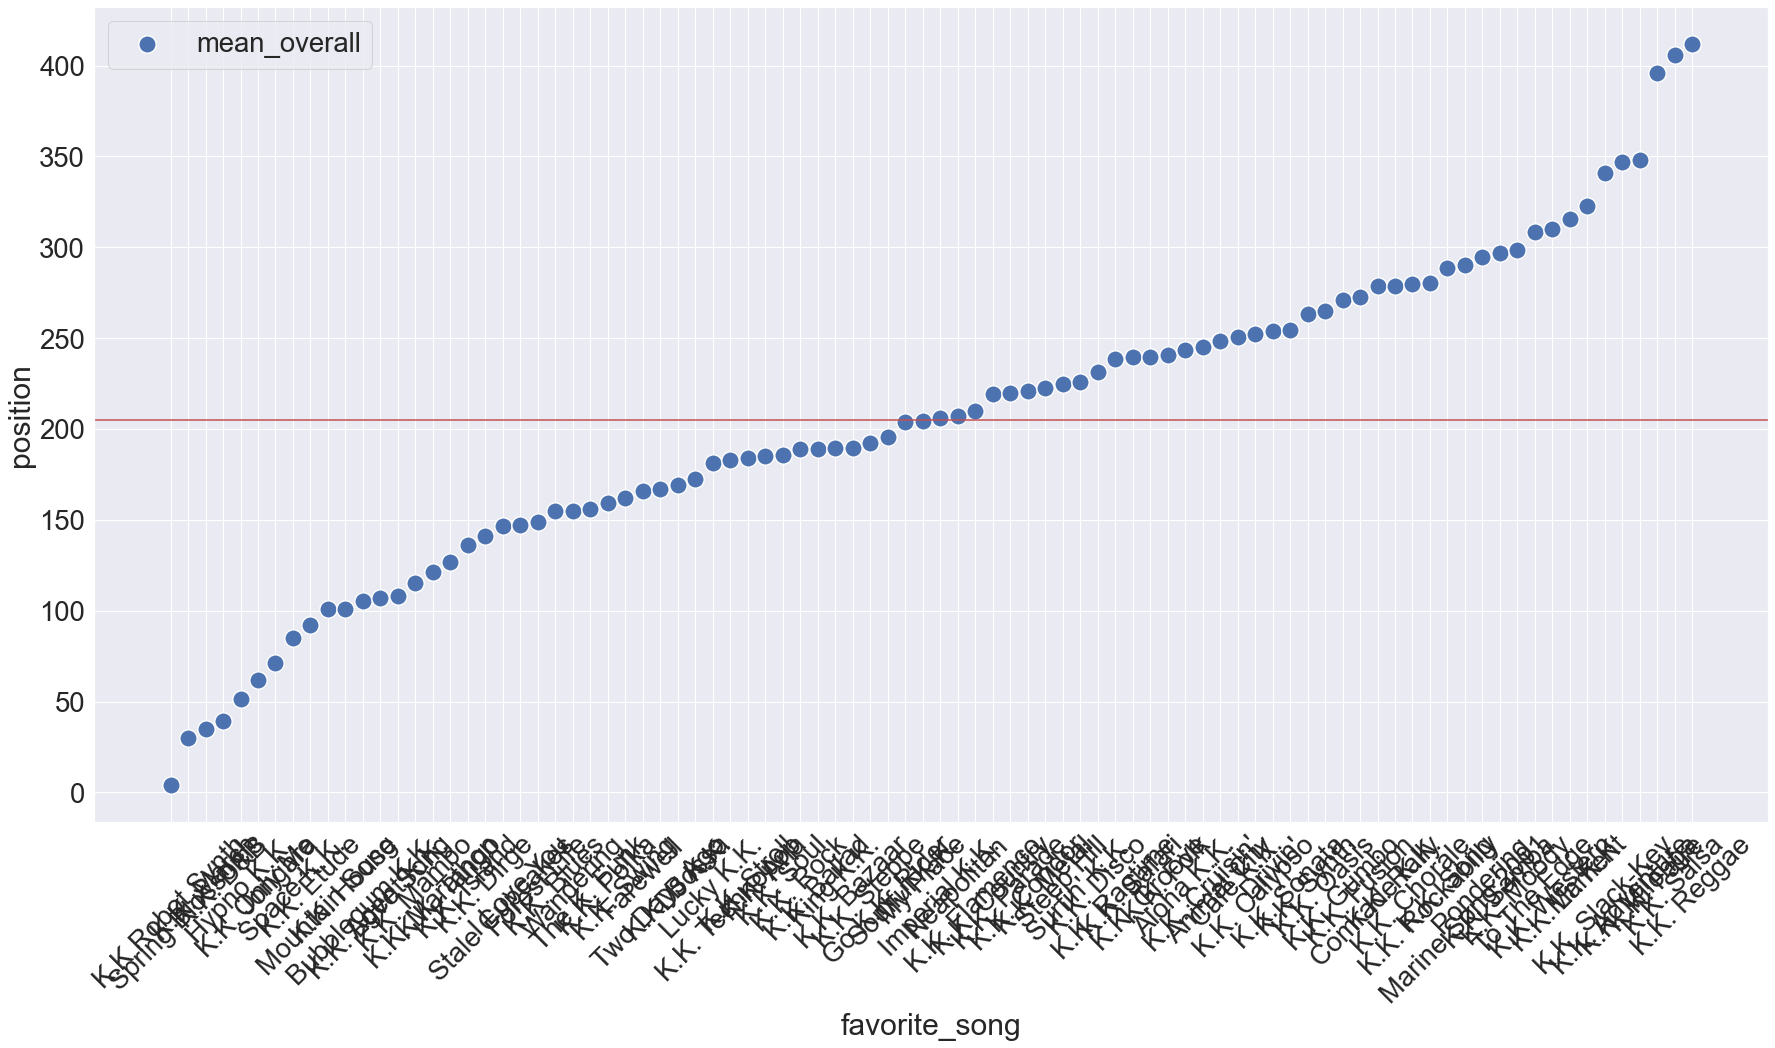

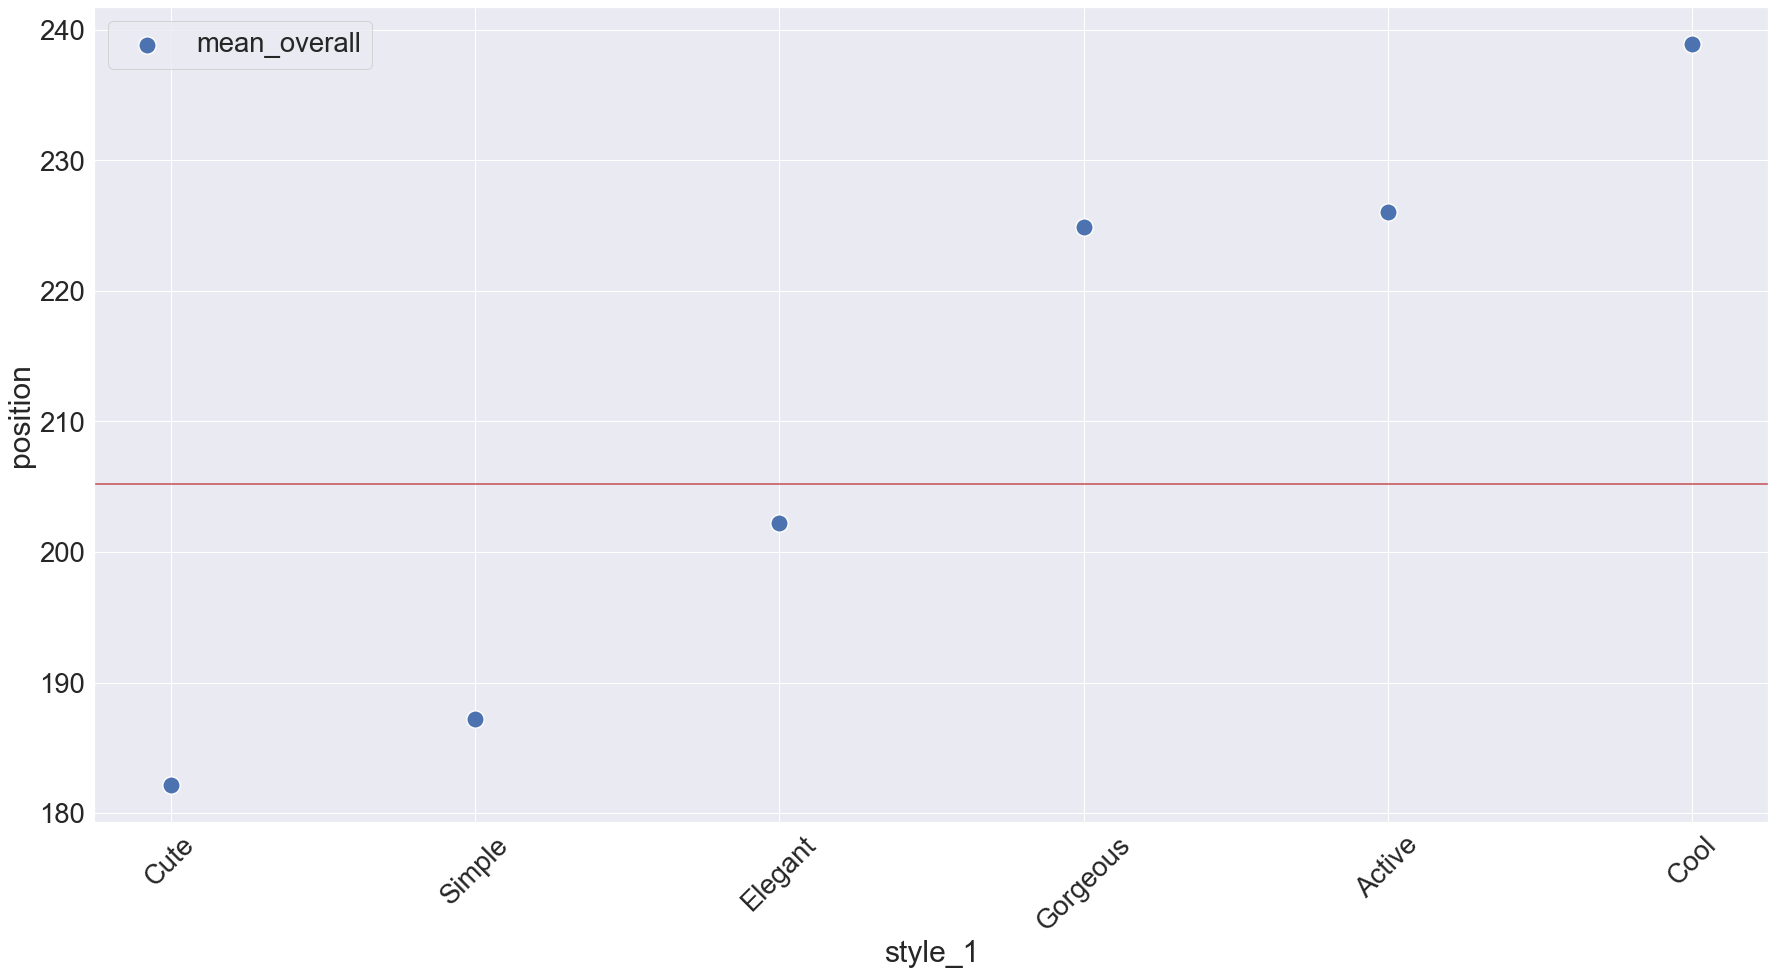

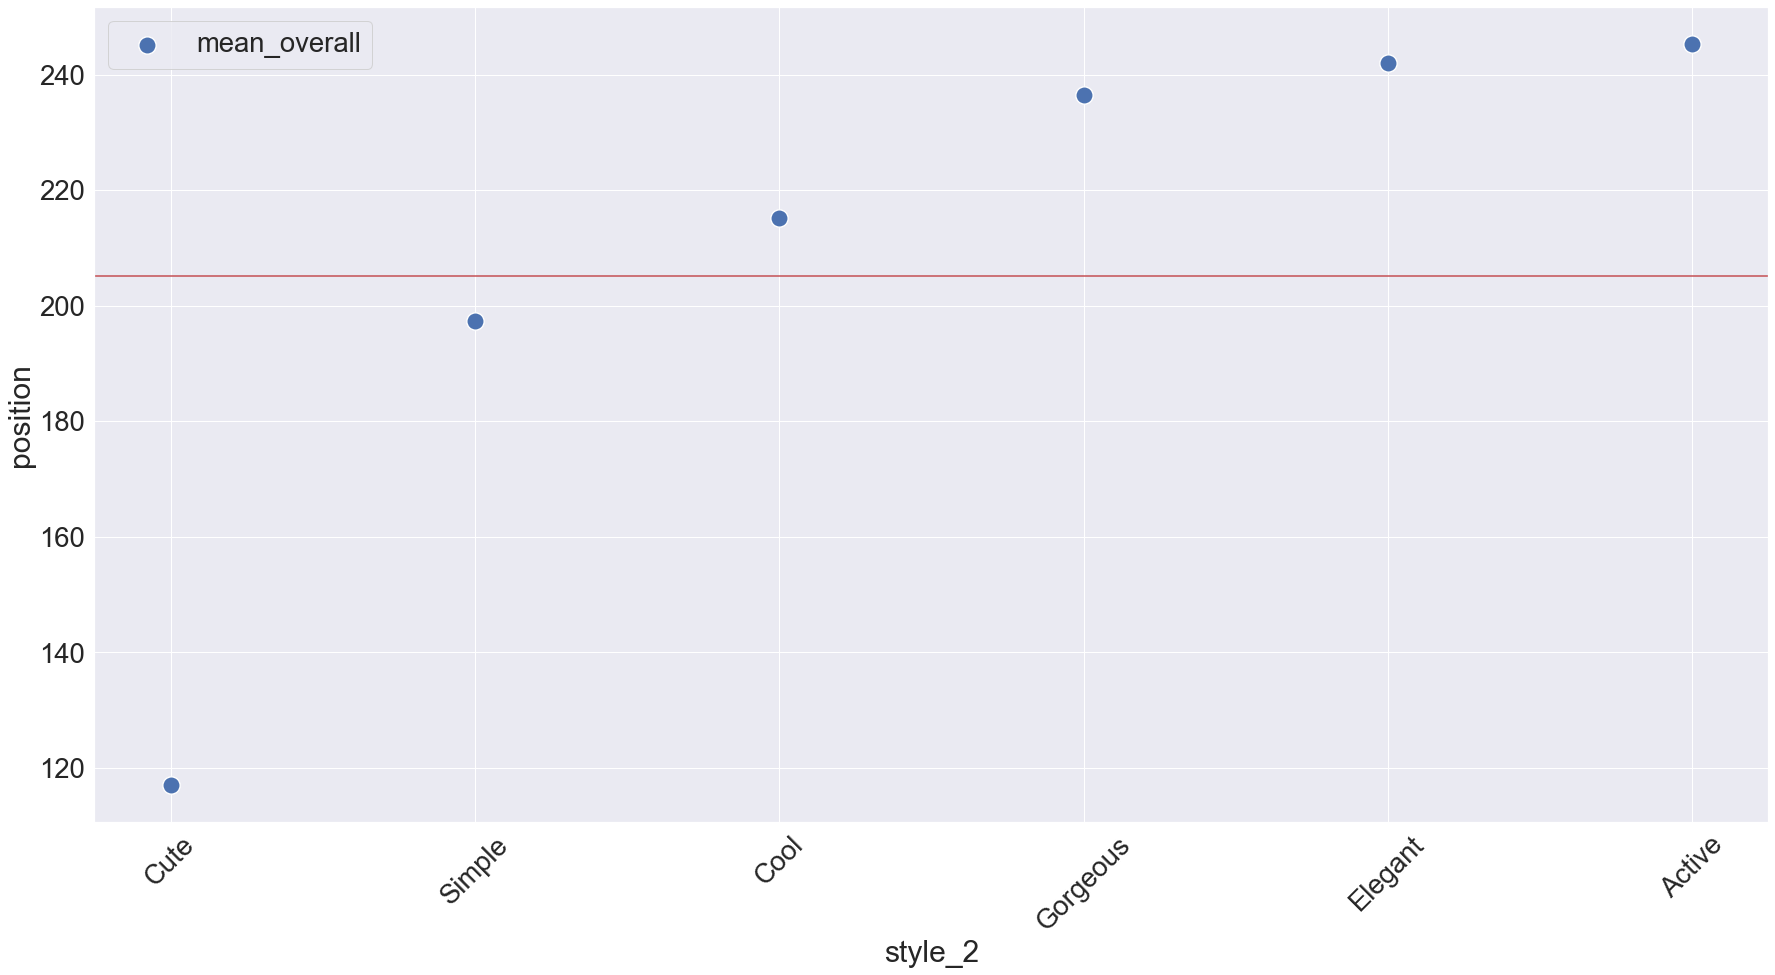

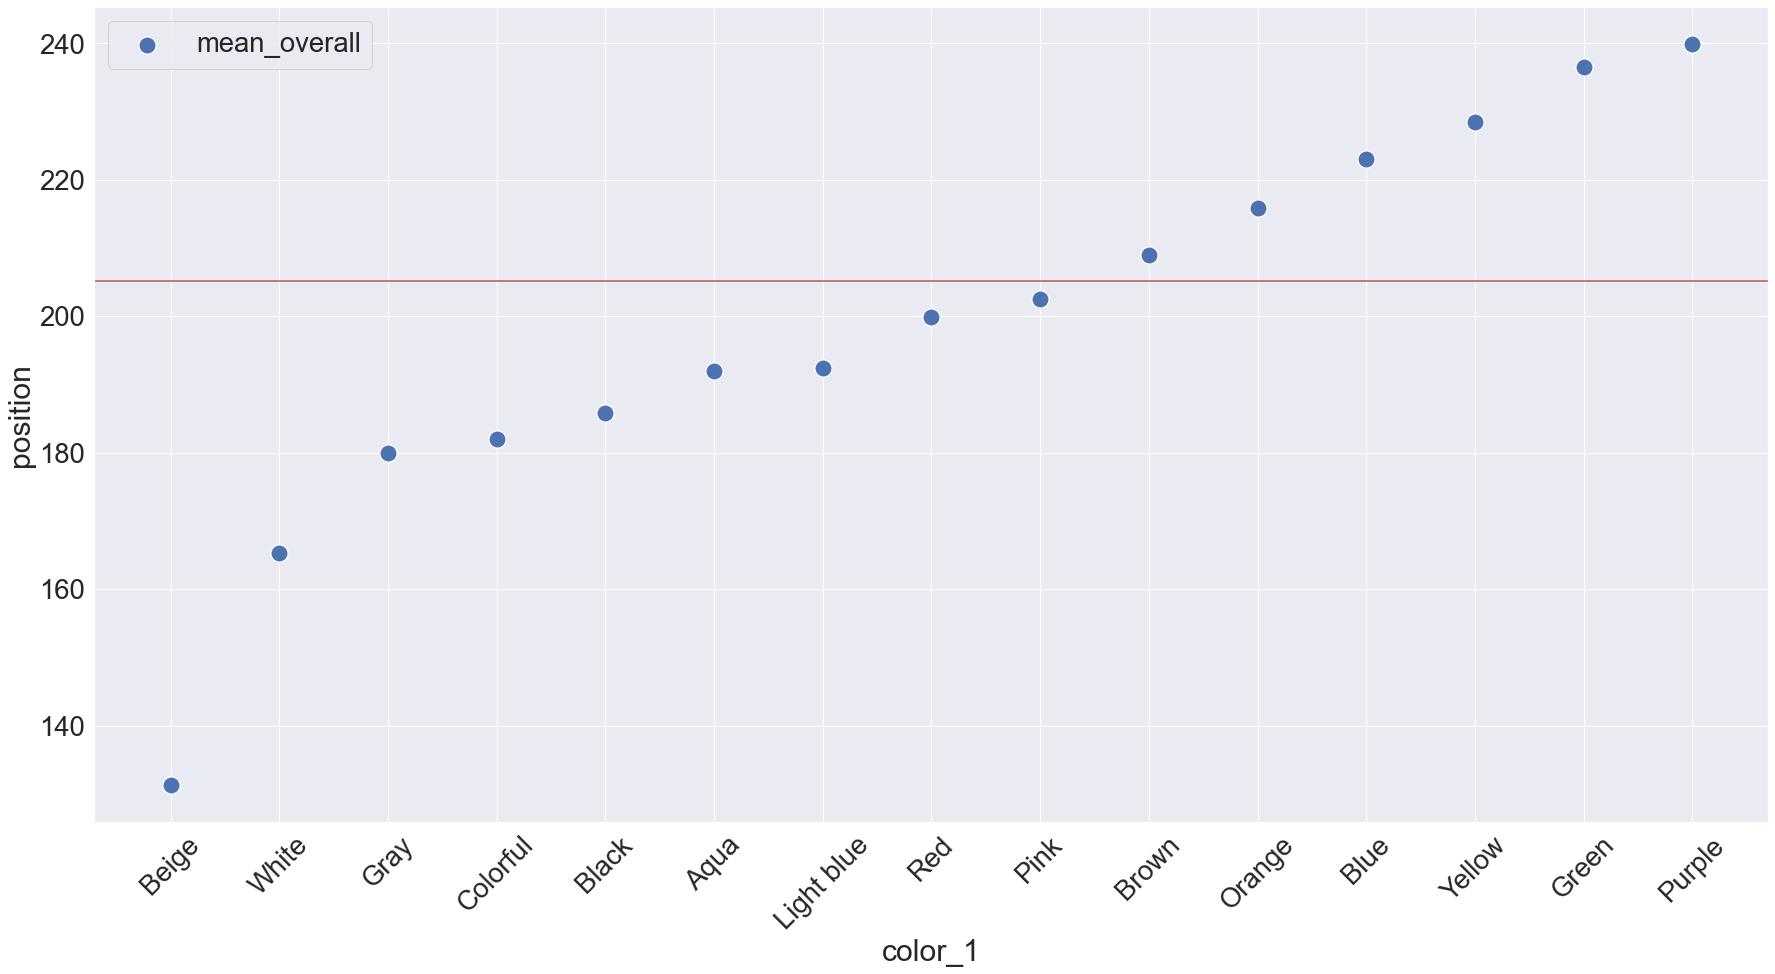

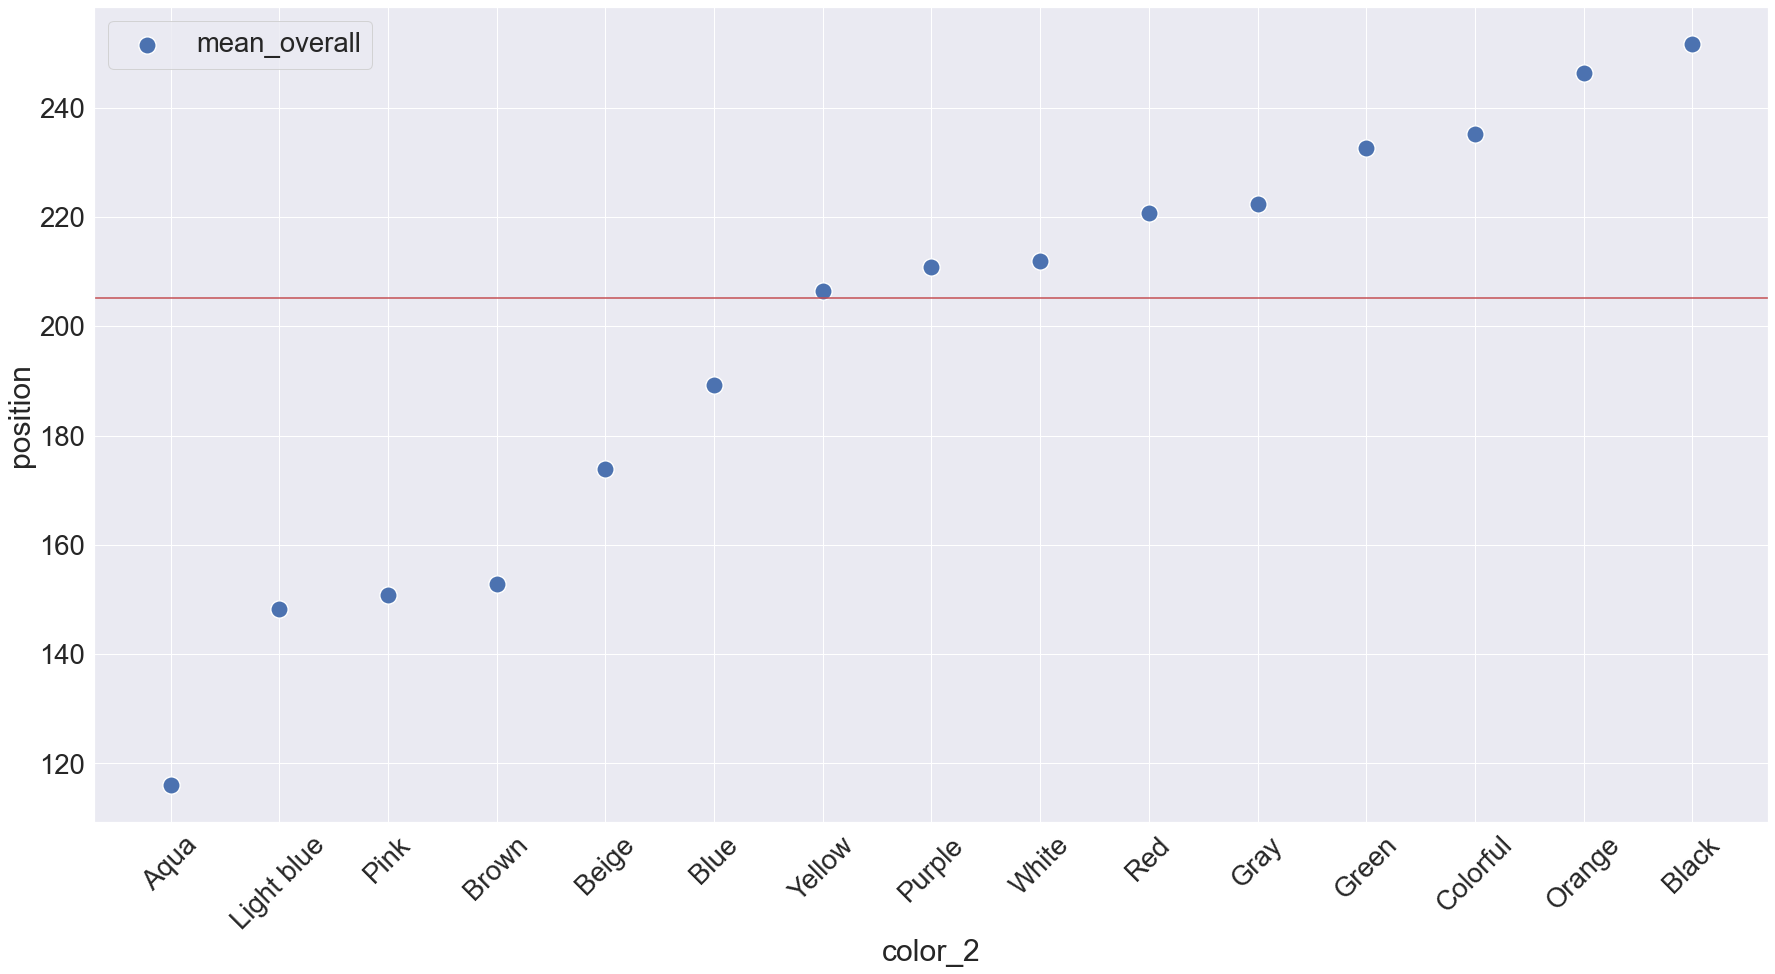

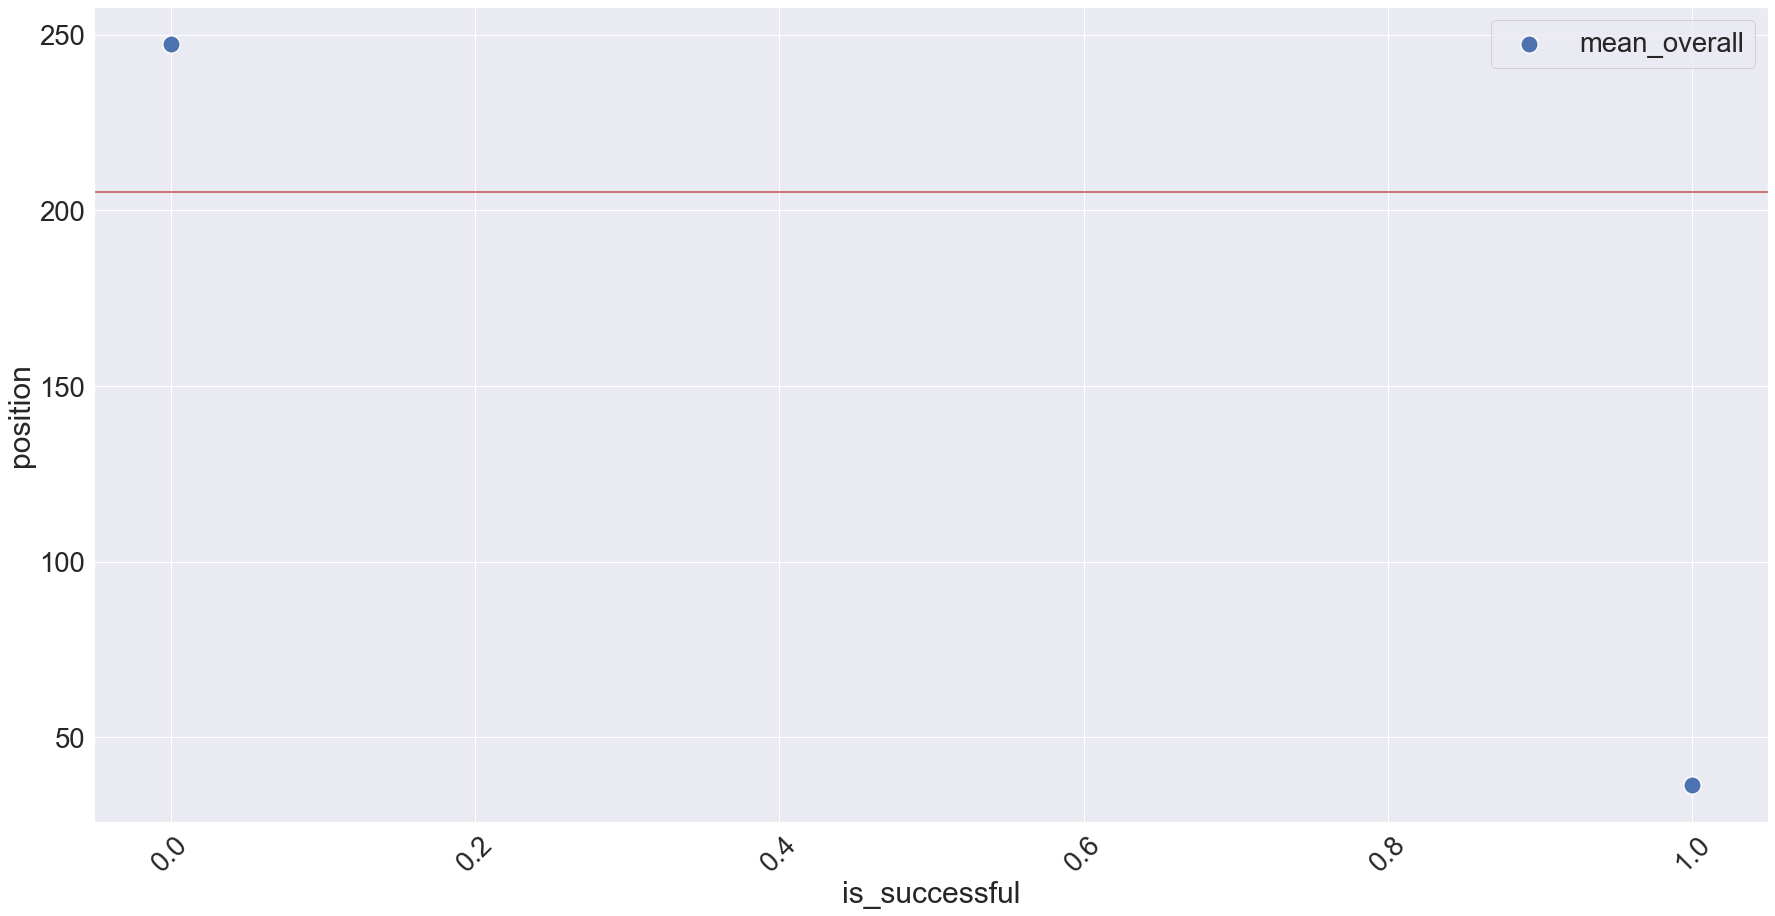

In [20]:
column_scatter_plots(train)

### Takeaways:

- The top 5 most popular species are Octopus, Wolf, Deer, Hamster, Cat
- It seems like female characters generally perform better than male characters
- The normal, peppy, lazy, and big sister personalities tend to perform better than the other personalities.
- The play and nature hobbies tend to do better than average, and the music hobby seems to perform right at average
- The cute, simple, and elegant style_1 perform better than average, while gorgeous and active perform about the same and cool performs the worst
- For the style_2 category, cute and simple still perform well, but elegant doesn't perform well at all. Additionally, cool does a lot better and active still doesn't do well.  
- For color_1 (which is typically the primary color of the character's clothes), beige, white, gray, colorful, and black perform the best while yellow, green, and purple do the worst. 
- For color_2, light blue, pink and brown do the best while black and orange do the worst
    - While aqua does extremely well, there is only a single piece of information to back it up. Because of this, I am excluding it as a top performing color
    

In [ ]:
## Taking a deeper look to at gender as it relates to 